# Heart Failure Prediction Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import chi2_contingency
import pathlib
import pickle
import time

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import umap
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import auc, roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

import torch ## Neural Net
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import itertools

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

import shap 

/Users/cocotero/.pyenv/versions/3.6.13/envs/heart-failure/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/cocotero/.pyenv/versions/3.6.13/envs/heart-failure/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA

In [2]:
base_path = str(pathlib.Path.cwd().parent)

In [3]:
data = pd.read_csv(f'{base_path}/data/data.csv')

In [4]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Descriptive Analytics

In [5]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
data.shape

(918, 12)

In [7]:
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

#### Univariate analisis

###### Numerical Features

In [8]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'FastingBS', 'ST_Slope', 'HeartDisease']

In [9]:
def plot_variable_distribution(variable_name): 
    plt.figure(figsize=(20, 10))
    sns.histplot(data=data, x=f"{variable_name}")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/{variable_name}_distribution.png")
    plt.show()
    plt.close()

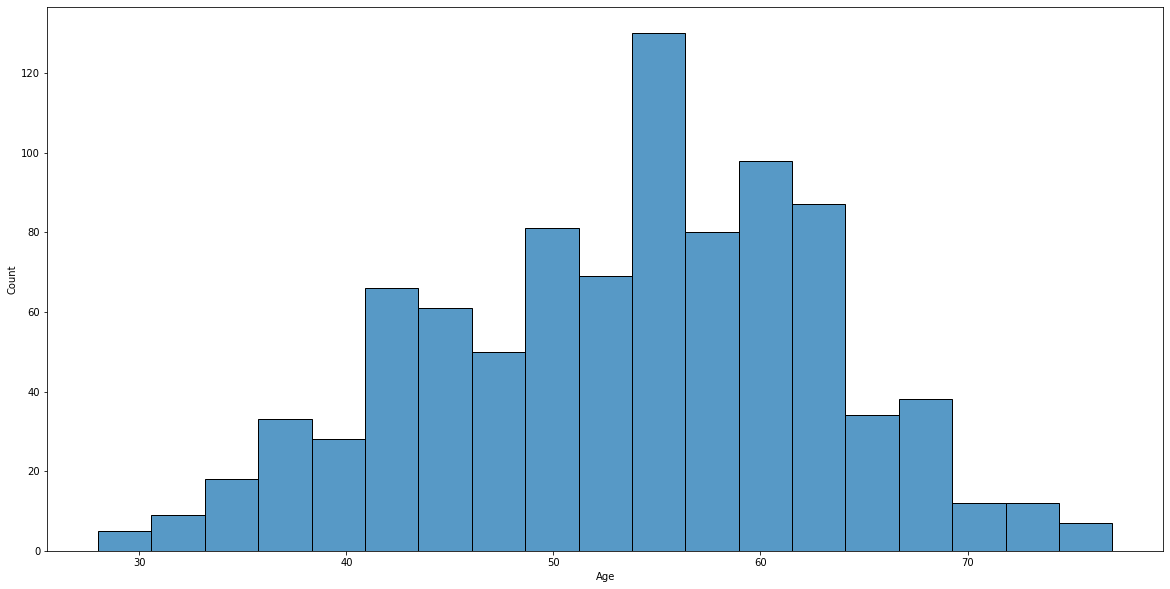

excess kurtosis of normal distribution (should be 0): -0.3905684960842244
skewness of normal distribution (should be 0): -0.19561273124487544


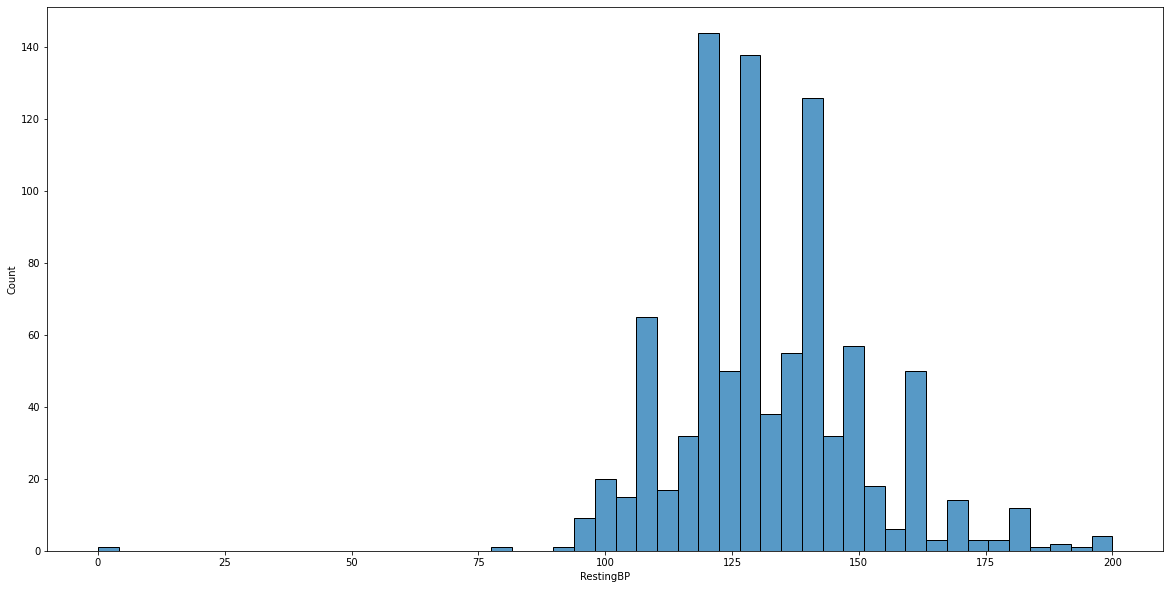

excess kurtosis of normal distribution (should be 0): 3.2469319615478724
skewness of normal distribution (should be 0): 0.17954532149156327


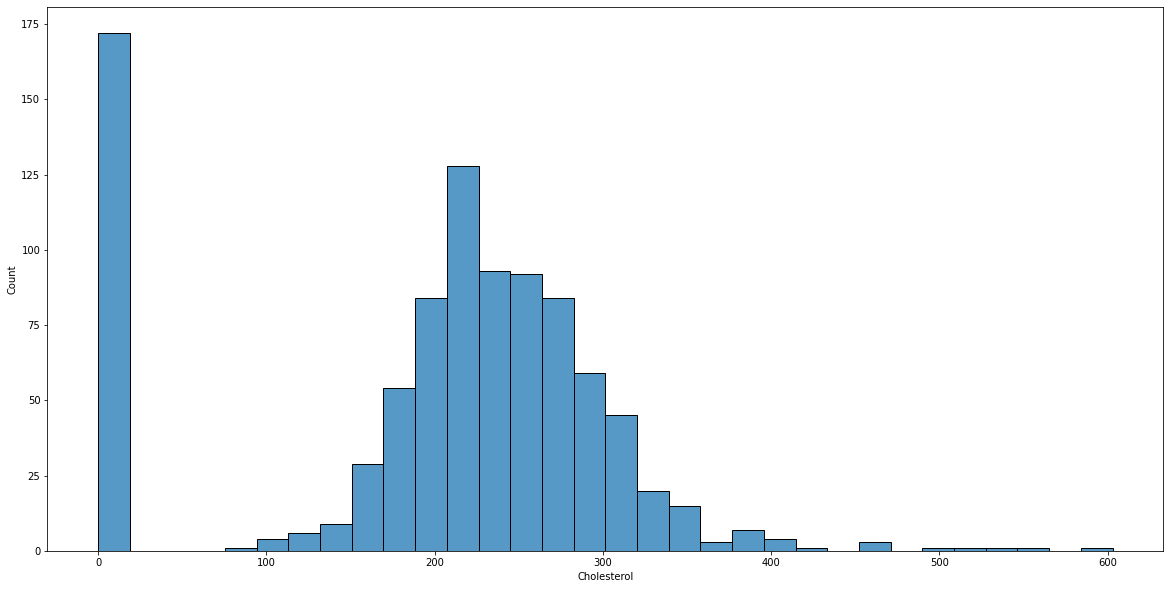

excess kurtosis of normal distribution (should be 0): 0.11103677697582448
skewness of normal distribution (should be 0): -0.6090891046626045


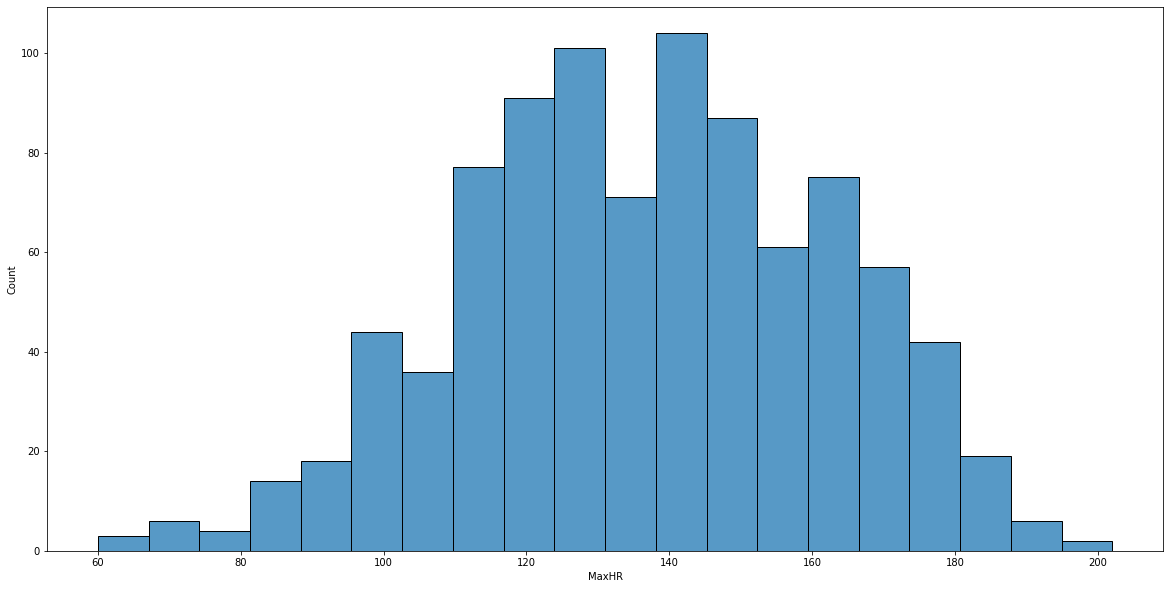

excess kurtosis of normal distribution (should be 0): -0.4523389391469048
skewness of normal distribution (should be 0): -0.14412342991429325


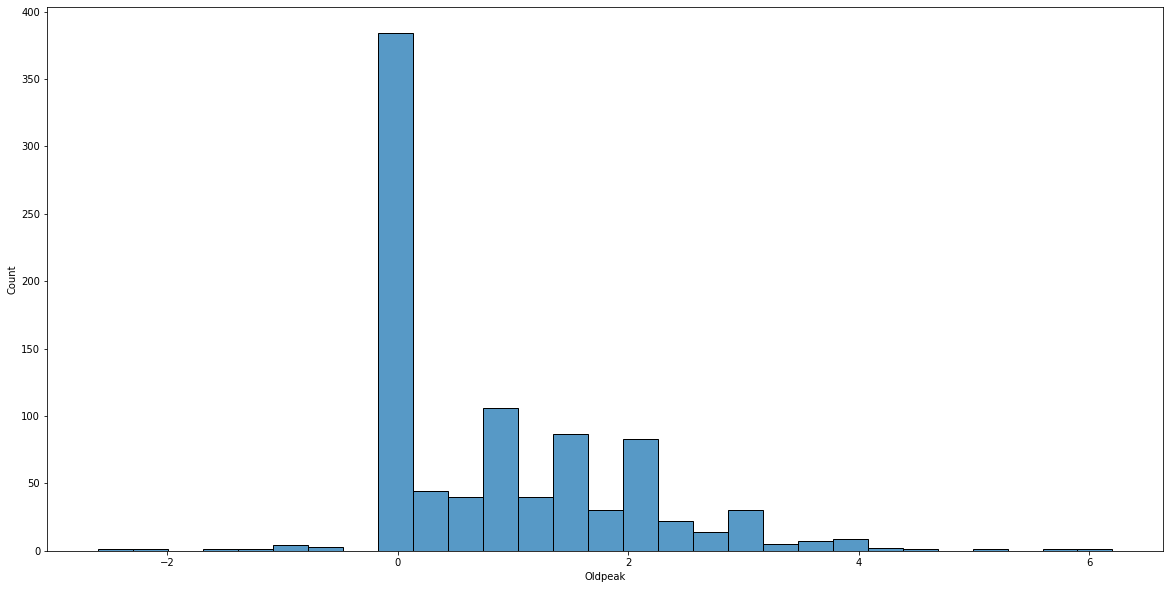

excess kurtosis of normal distribution (should be 0): 1.189992199237265
skewness of normal distribution (should be 0): 1.0211999031135828


In [10]:
for numerical_feature in numerical_features:
    plot_variable_distribution(numerical_feature)
    print( 'excess kurtosis of normal distribution (should be 0): {}'.format(kurtosis(data[f'{numerical_feature}'])))
    print( 'skewness of normal distribution (should be 0): {}'.format(skew(data[f'{numerical_feature}'])))

###### Categorical Features

In [11]:
def plot_categorical_feature_distribution(variable_name):
    plt.figure(figsize=(20, 10))
    ax = sns.countplot(x=f"{variable_name}", data=data)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
    plt.xlabel(f"{column}")
    plt.savefig(f"../results/EDA/{variable_name}_distribution.png")
    plt.show()
    plt.close()

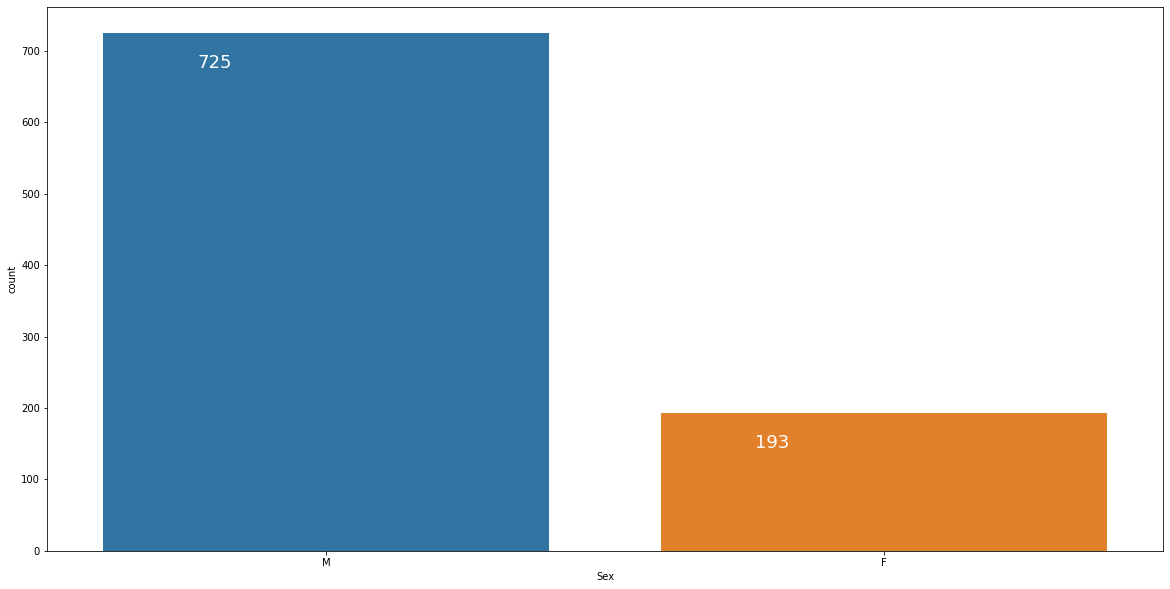

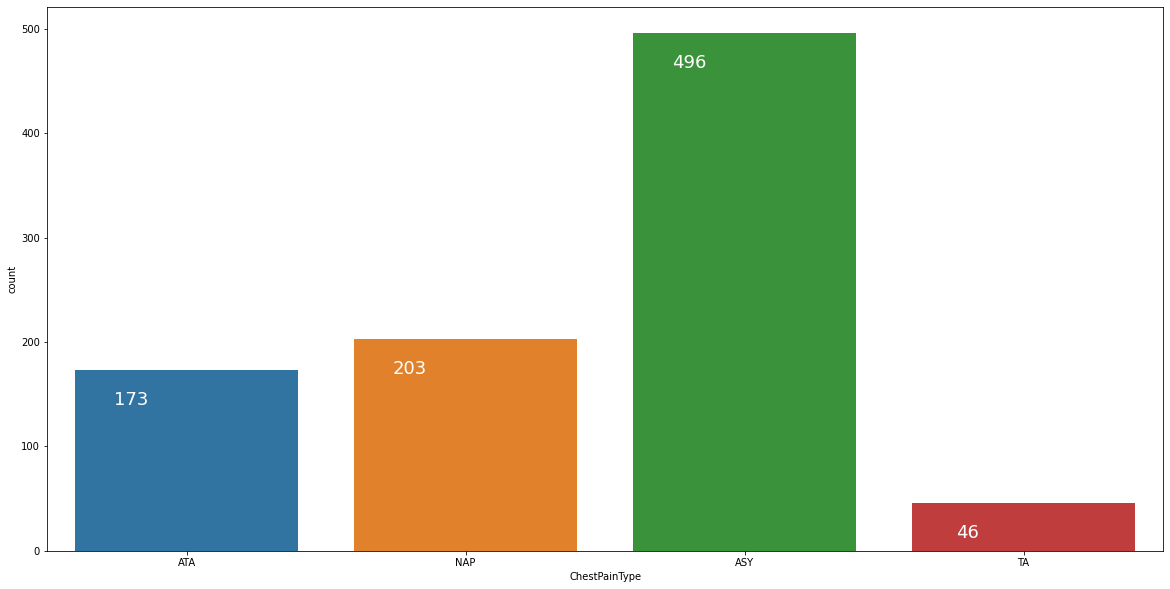

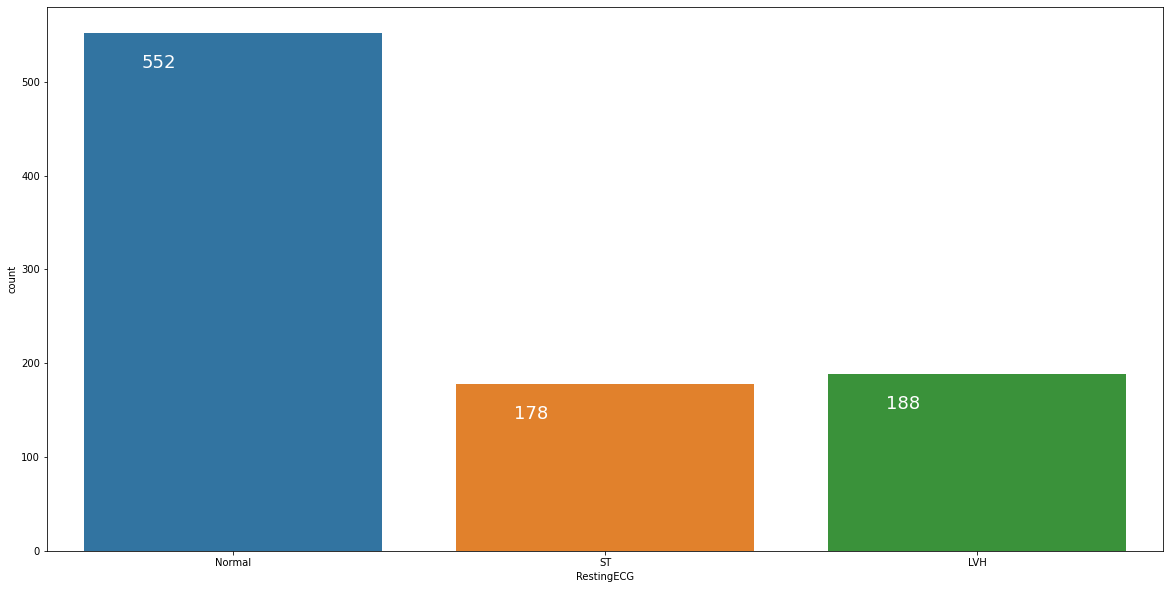

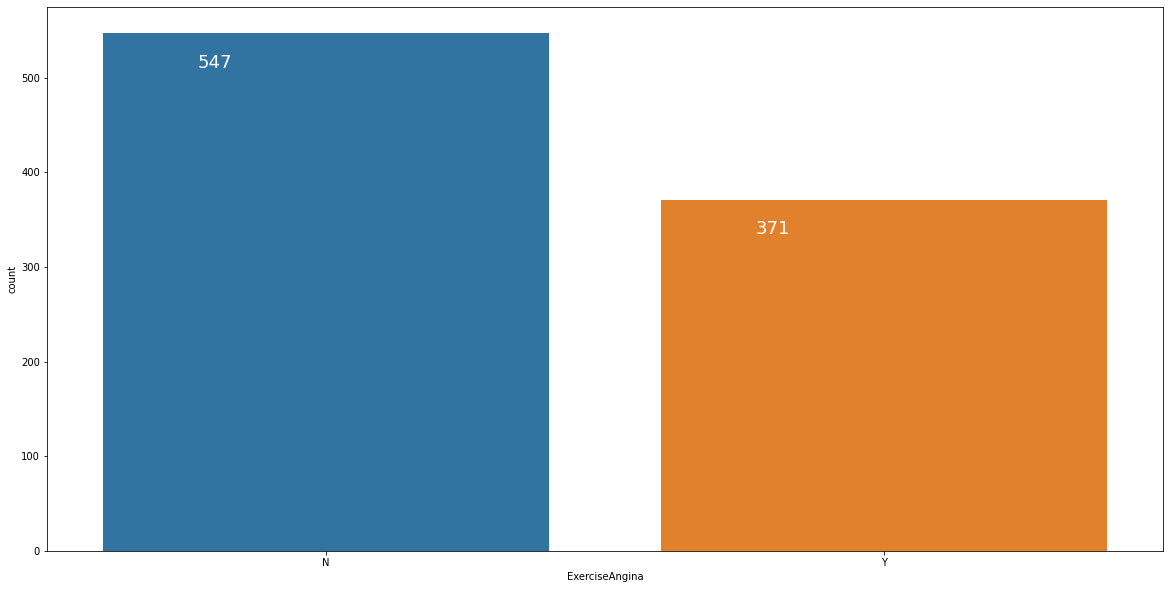

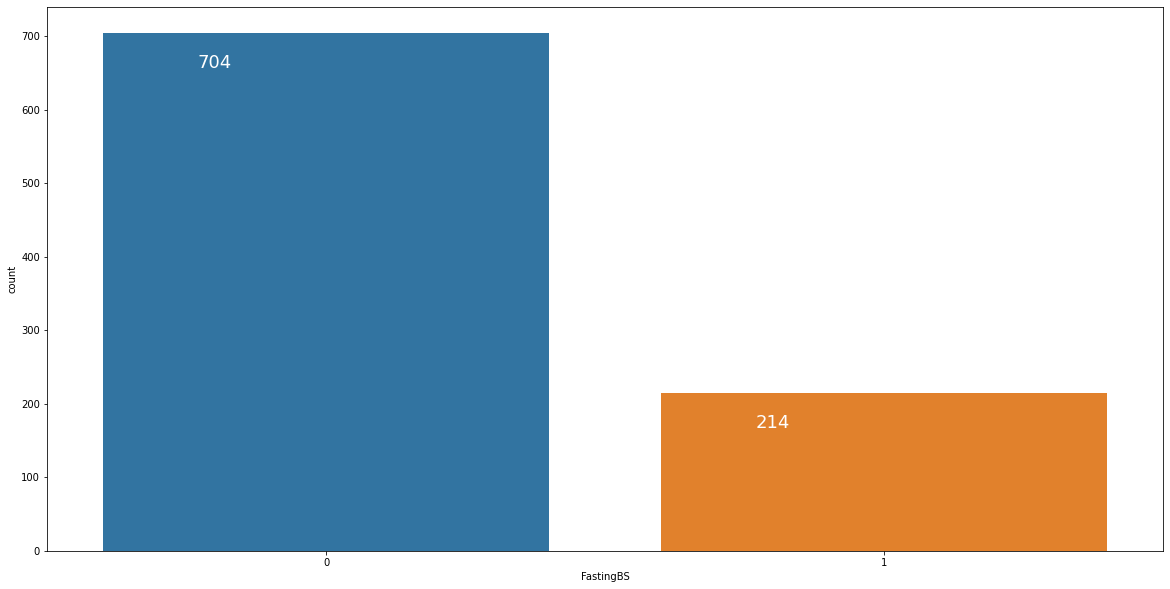

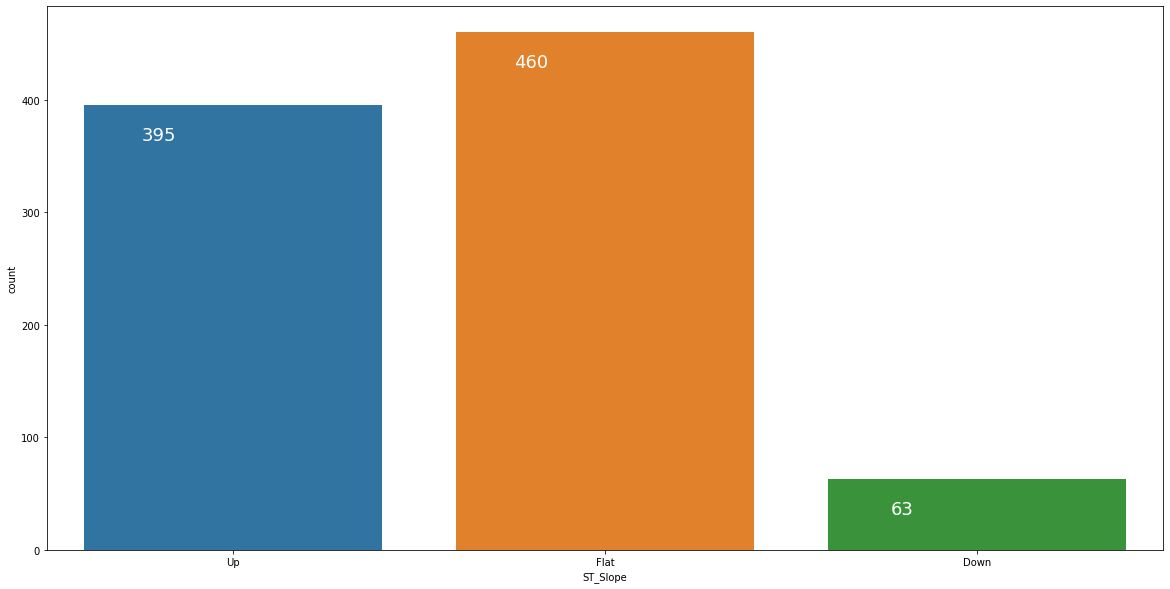

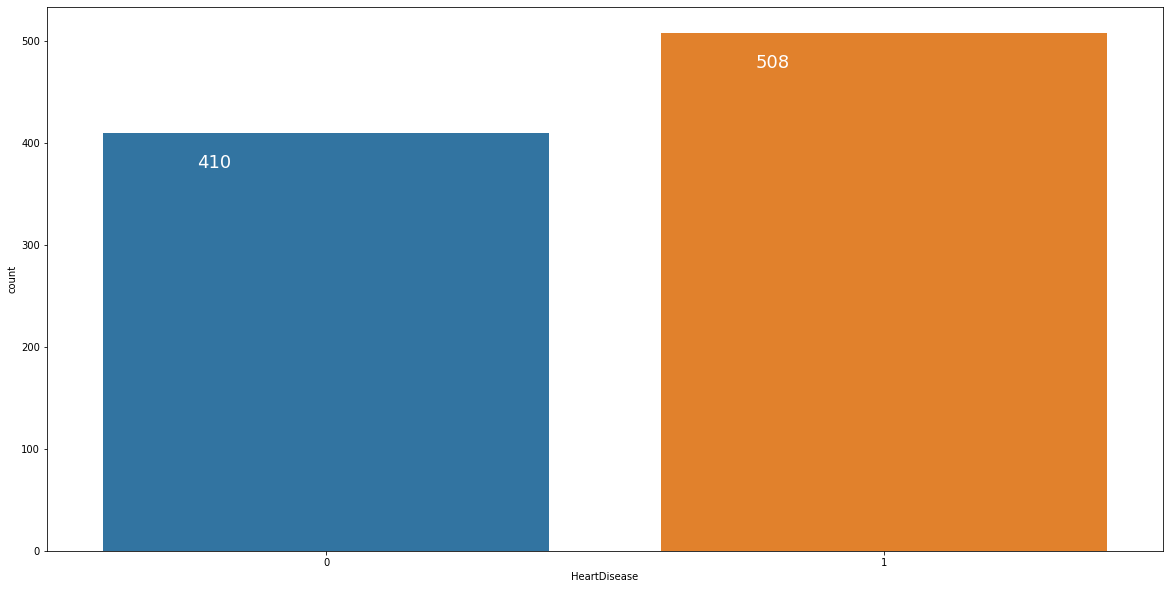

In [12]:
for column in categorical_features: 
    plot_categorical_feature_distribution(column)

We can conclude that the dataset is not imbalaced, since there is no minorty class and we have a almost 50 / 50 ratio between those how suffered a heart failure and those that no

In [13]:
symetric_distribution_features = ['Age', 'Cholesterol', 'MaxHR']

In [14]:
asymetric_distribution_features = ['RestingBP', 'Oldpeak']

In [15]:
# Dataset 1 is the raw dataset, variables will not have any modification in here
dataset_1 = data.copy()

### Missing Values

<AxesSubplot:>

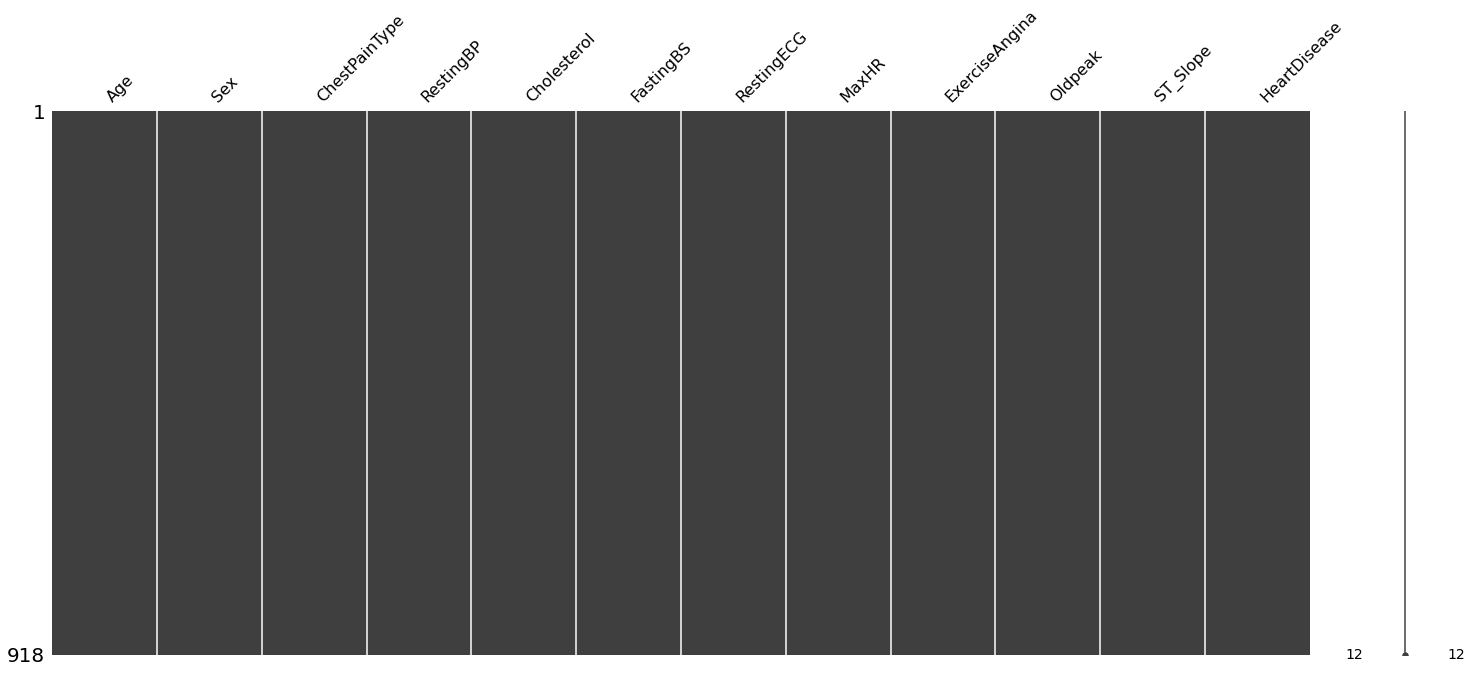

In [16]:
msno.matrix(data)

<AxesSubplot:>

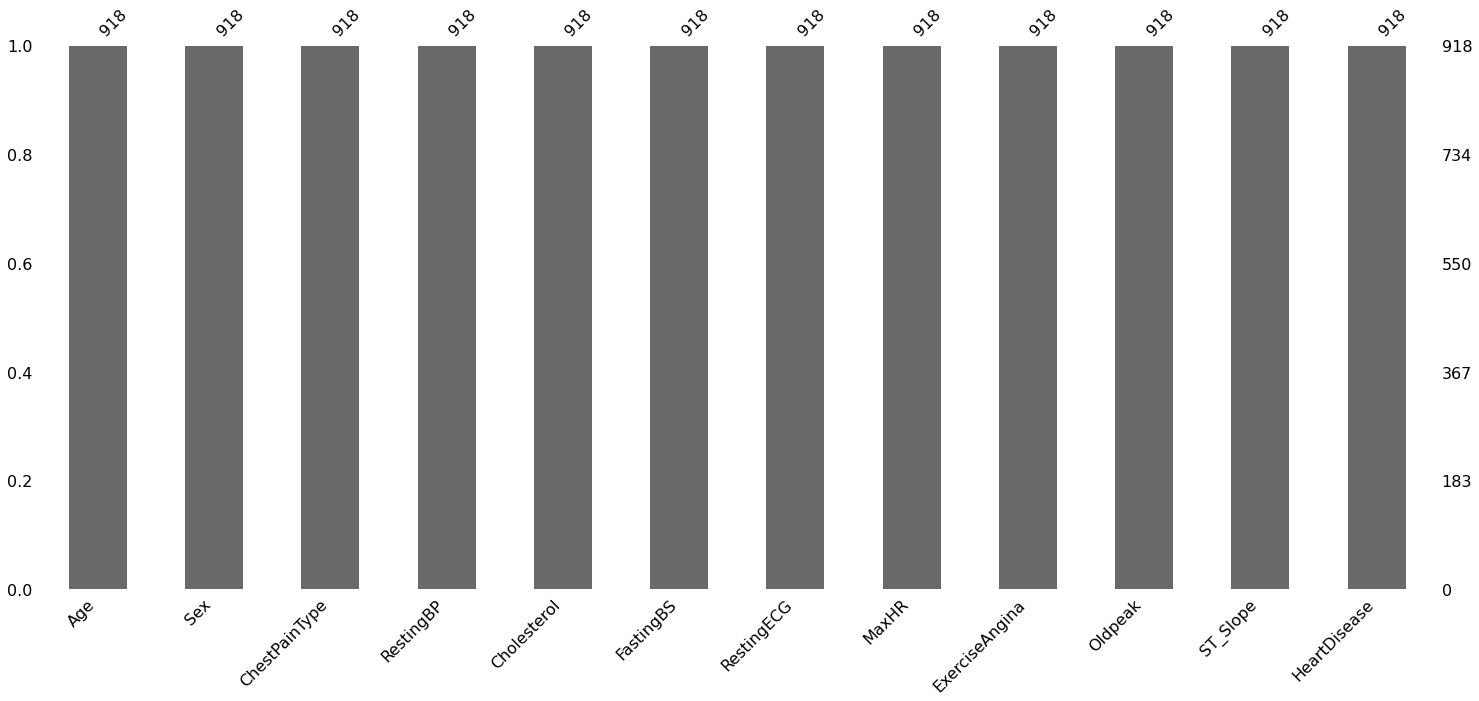

In [17]:
msno.bar(data)

There are no missing values in this dataset. But there are some anomalies in the cholesterol feature.

In [18]:
# Count number of zeros in all columns of Dataframe to detect possible wrong values
for column_name in data.columns:
    column = data[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print(f'Count of zeros in column: {column_name} is {count}, {count/data.shape[0]*100} % of the data ')

Count of zeros in column: Age is 0, 0.0 % of the data 
Count of zeros in column: Sex is 0, 0.0 % of the data 
Count of zeros in column: ChestPainType is 0, 0.0 % of the data 
Count of zeros in column: RestingBP is 1, 0.10893246187363835 % of the data 
Count of zeros in column: Cholesterol is 172, 18.736383442265794 % of the data 
Count of zeros in column: FastingBS is 704, 76.68845315904139 % of the data 
Count of zeros in column: RestingECG is 0, 0.0 % of the data 
Count of zeros in column: MaxHR is 0, 0.0 % of the data 
Count of zeros in column: ExerciseAngina is 0, 0.0 % of the data 
Count of zeros in column: Oldpeak is 368, 40.08714596949891 % of the data 
Count of zeros in column: ST_Slope is 0, 0.0 % of the data 
Count of zeros in column: HeartDisease is 410, 44.66230936819172 % of the data 


#### Cholesterol

In [19]:
number_of_zeroes = data['Cholesterol'][data['Cholesterol'] == 0].count()
print(f'There are {number_of_zeroes} 0´s in Cholesterol')

There are 172 0´s in Cholesterol


#### Resting BP

In [20]:
number_of_zeroes = data['RestingBP'][data['RestingBP'] == 0].count()
print(f'There are {number_of_zeroes} 0´s in RestingBP')

There are 1 0´s in RestingBP


#### Mean Inputation

In [21]:
dataset_2_1 = data.copy()
dataset_2_1['Cholesterol']=dataset_2_1['Cholesterol'].mask(dataset_2_1['Cholesterol']==0).fillna(dataset_2_1['Cholesterol'].mean())
dataset_2_1['RestingBP']=dataset_2_1['RestingBP'].mask(dataset_2_1['RestingBP']==0).fillna(dataset_2_1['RestingBP'].mean())

#### Regression Inputation

In [22]:
dataset_2_2 = data.copy()

dataset_2_2['Cholesterol']=dataset_2_2['Cholesterol'].mask(dataset_2_2['Cholesterol']==0)
dataset_2_2['RestingBP']=dataset_2_2['RestingBP'].mask(dataset_2_2['RestingBP']==0)

def inpute_via_regression(data):
    imputer = IterativeImputer(random_state=42)
    data = imputer.fit_transform(data)
    return data

### Outlier Detection

In [23]:
dataset_3_1 = data.copy()
dataset_3_2 = data.copy()

In [24]:
def mean_3_std(variable_name, data):
    data_mean, data_std = np.mean(data[f'{variable_name}']), np.std(data[f'{variable_name}'])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers_lower = [x for x in data[f'{variable_name}'] if x < lower]
    outliers_upper = [x for x in data[f'{variable_name}'] if x > upper]
    print(f'Variable {variable_name}: Lower outliers {outliers_lower}, Upper outliers {outliers_upper}, boundaries {lower}, {upper}')
    return data[(data[f'{variable_name}']>lower) & (data[f'{variable_name}']<upper)]

In [25]:
def plot_intercuartile_range(variable_name):
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=data, x=f"{variable_name}")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/{variable_name}_outliers.png")
    plt.show()
    plt.close()

In [26]:
for symetric_distribution_feature in symetric_distribution_features:
    mean_3_std(symetric_distribution_feature, data.copy())

Variable Age: Lower outliers [], Upper outliers [], boundaries 25.22846069772688, 81.79332579464784
Variable Cholesterol: Lower outliers [], Upper outliers [529, 603, 564], boundaries -129.1740884232252, 526.7732169635302
Variable MaxHR: Lower outliers [60], Upper outliers [], boundaries 60.46997896579296, 213.14875741764928


In [27]:
def iqr(variable_name, data):
    q75, q25 = np.percentile(data[f'{variable_name}'], [75 ,25])
    iqr = q75 - q25
    lower = q25 - iqr*1.5
    upper = q75 + iqr*1.5
    outliers_lower = [x for x in data[f'{variable_name}'] if x < lower]
    outliers_upper = [x for x in data[f'{variable_name}'] if x > upper]
    print(f'Variable {variable_name}: Lower outliers {outliers_lower}, {len(outliers_lower)}, Upper outliers {outliers_upper}, {len(outliers_upper)}, boundaries {lower}, {upper}')
    return data[(data[f'{variable_name}']>lower) & (data[f'{variable_name}']<upper)]

In [28]:
for asymetric_distribution_feature in asymetric_distribution_features:
    iqr(asymetric_distribution_feature, data.copy())

Variable RestingBP: Lower outliers [80, 0], 2, Upper outliers [190, 180, 180, 180, 200, 180, 180, 180, 200, 185, 200, 180, 180, 178, 172, 180, 190, 174, 178, 180, 200, 192, 178, 180, 180, 172], 26, boundaries 90.0, 170.0
Variable Oldpeak: Lower outliers [-2.6], 1, Upper outliers [4.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.2, 4.0, 5.6, 3.8, 4.2, 6.2, 4.4, 4.0], 15, boundaries -2.25, 3.75


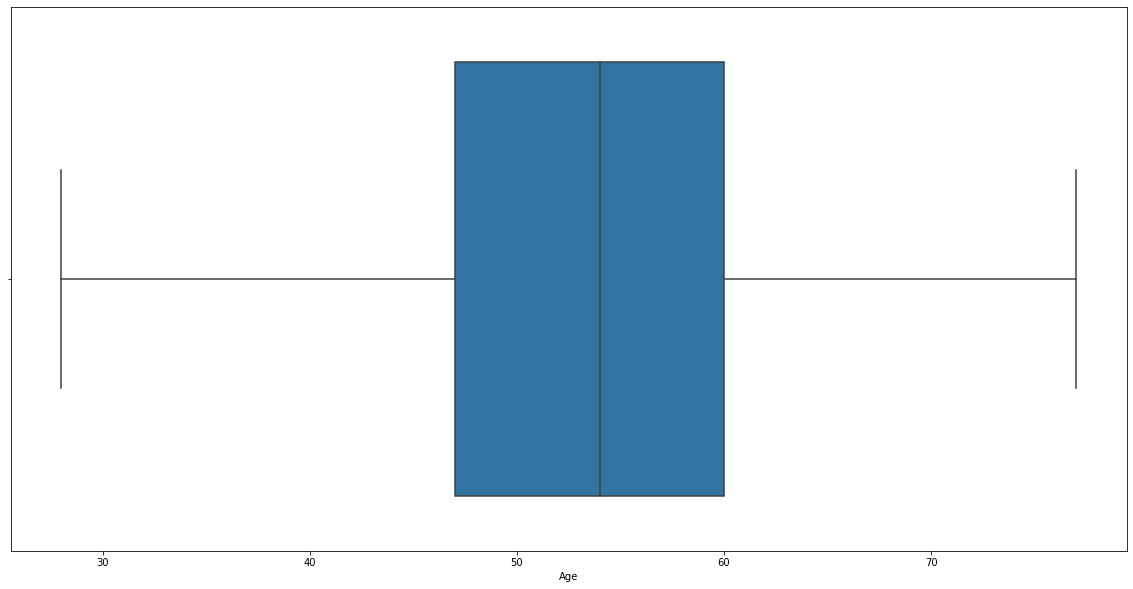

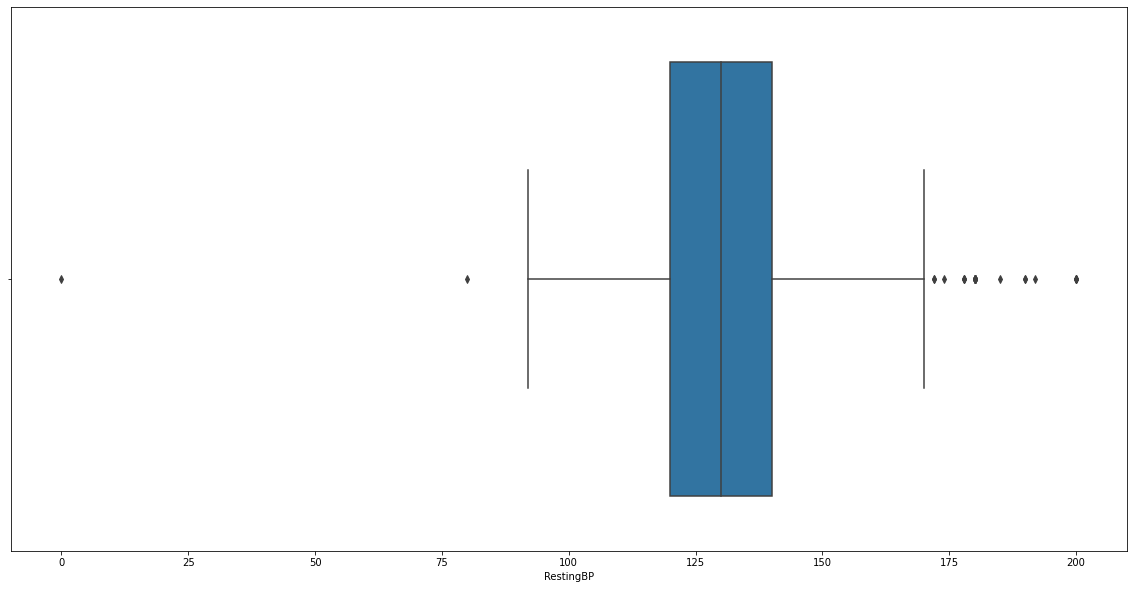

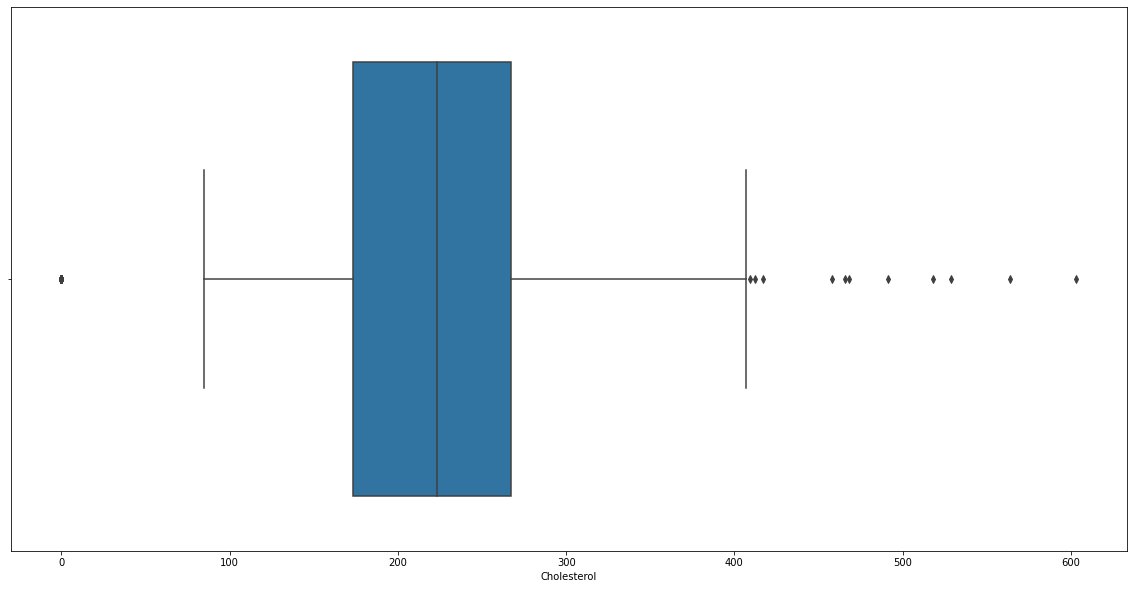

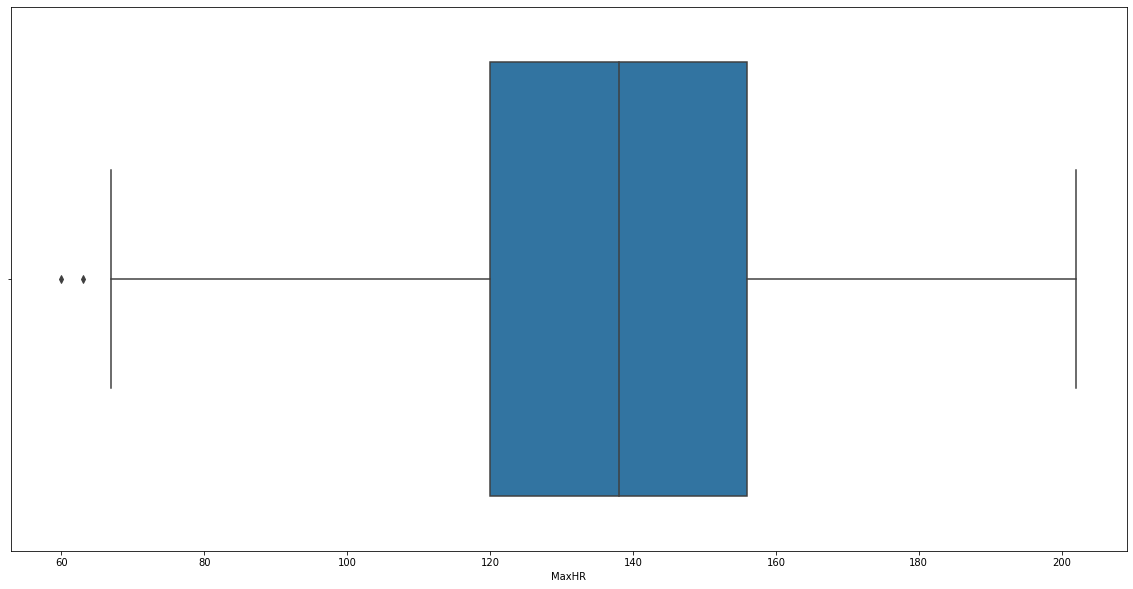

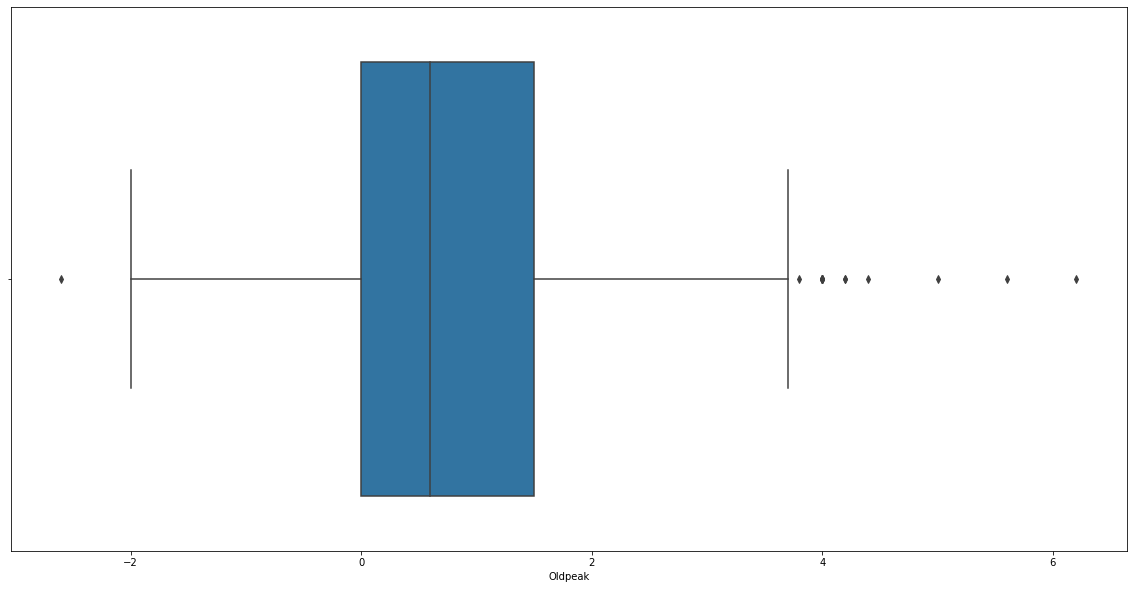

In [29]:
for numerical_feature in numerical_features:
    plot_intercuartile_range(numerical_feature)

### Multivariate Analysis

The target column in this case is very clear, HeartDisease. We already know that it is not balanced, but know we will try to detect any pattern. 

#### Numerical features: Plots

In [30]:
def distribution_acording_to_target_value(variable_name):
    plt.figure(figsize=(20, 10))
    plt.title(f"Distribution of {variable_name}")
    ax = sns.violinplot(x="HeartDisease", y=f"{variable_name}",
                    data=data, palette="Set2", split=True,
                    scale="count")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/violin_{variable_name}.png")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(20, 10))
    ax = sns.boxplot(x="HeartDisease", y=f"{variable_name}", data=data, palette="Set2")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/distribution_{variable_name}_target.png")
    plt.show()
    plt.close()

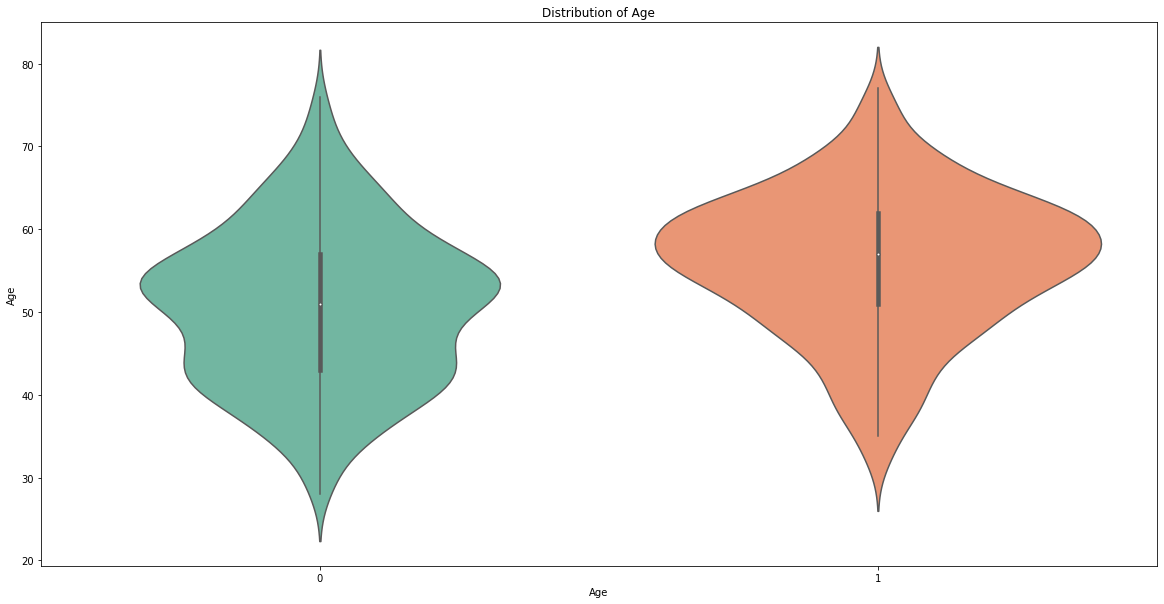

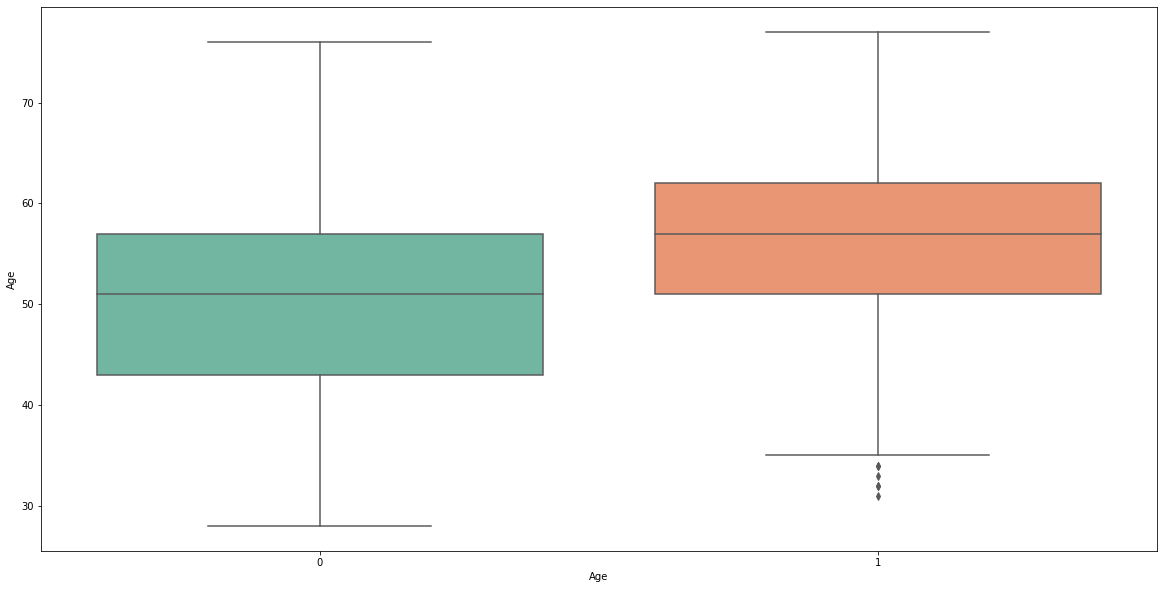

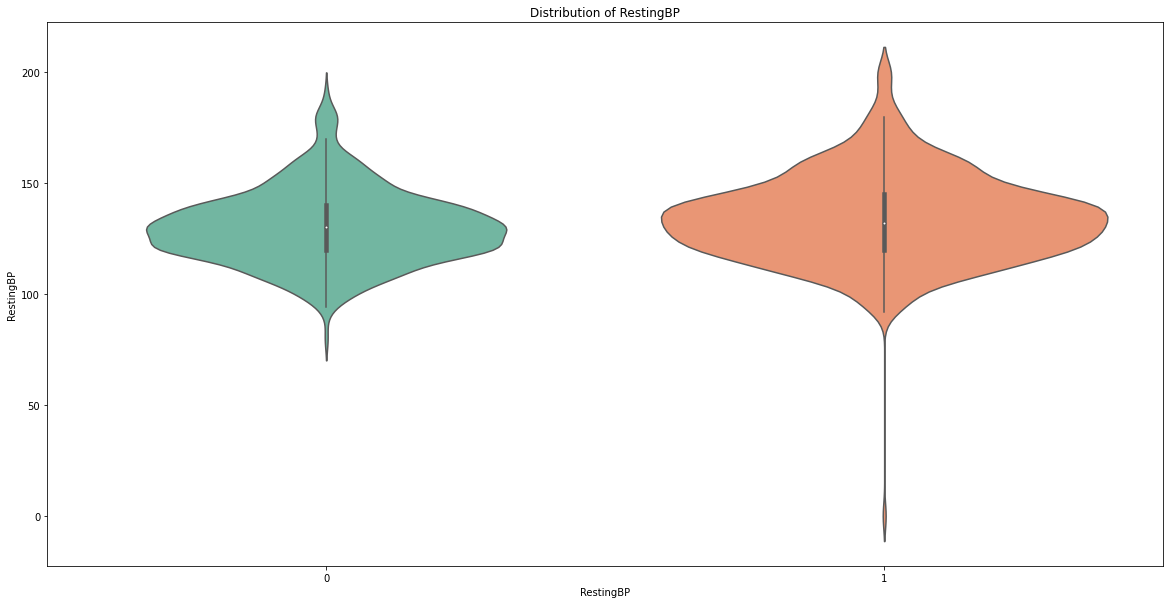

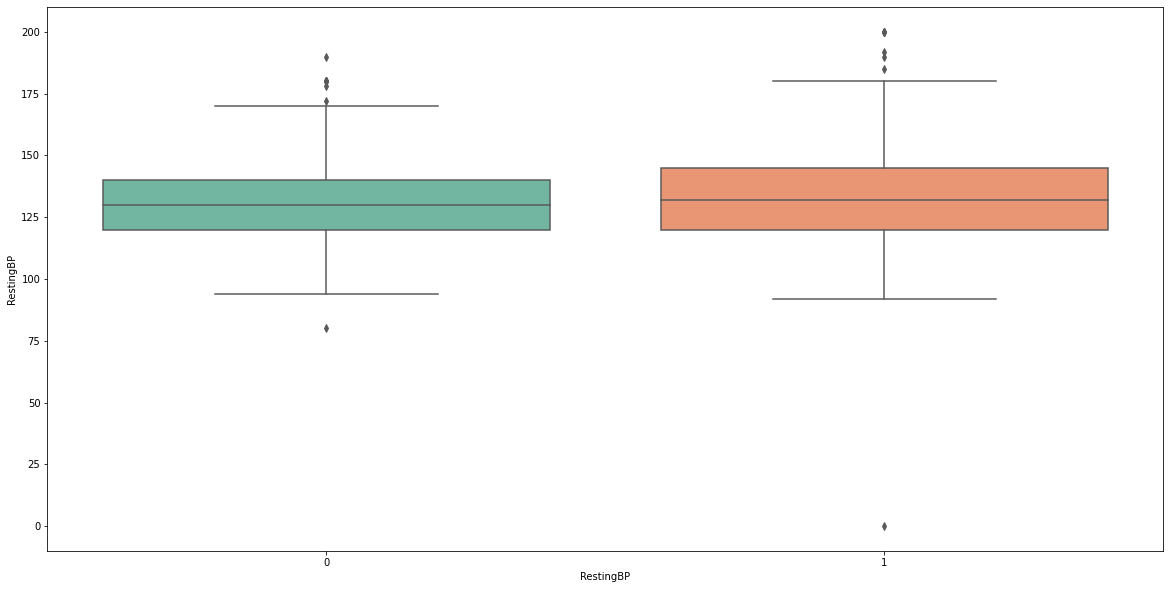

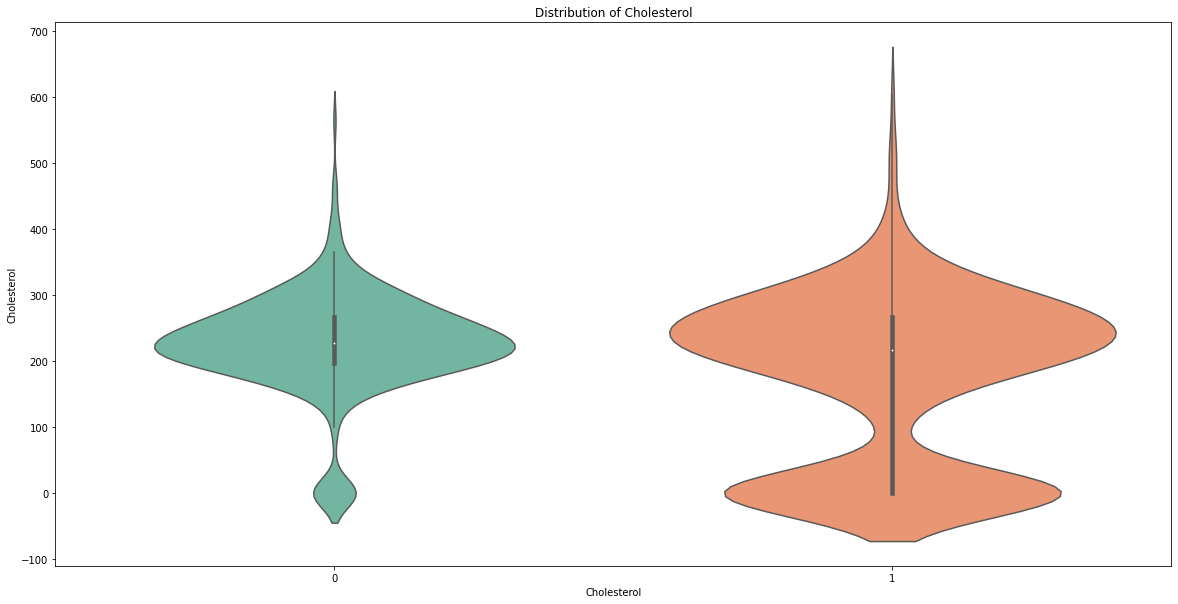

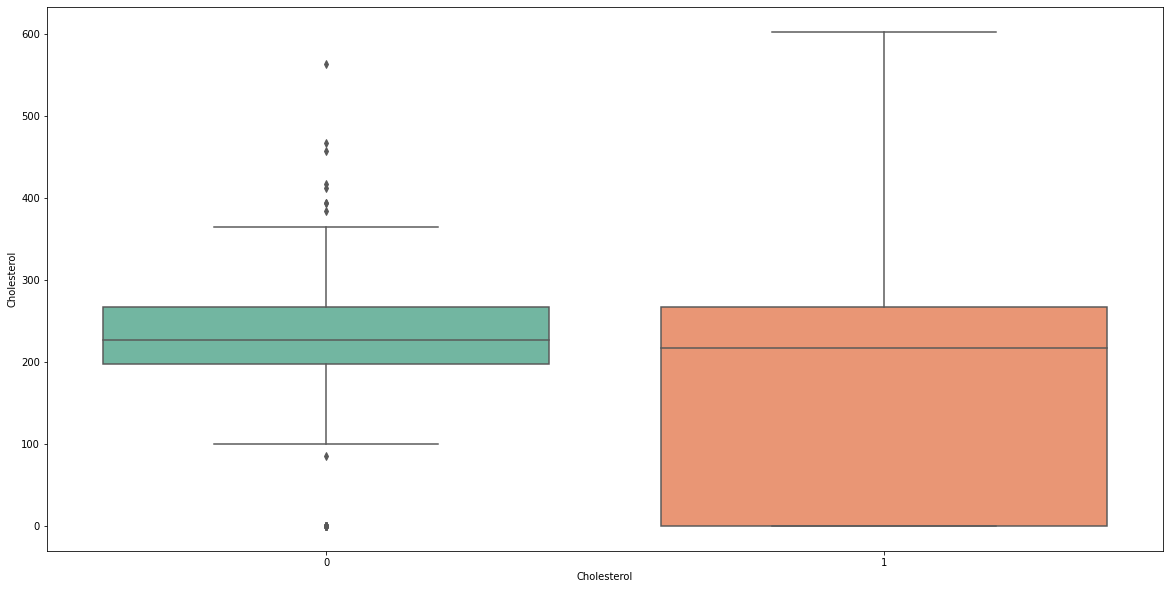

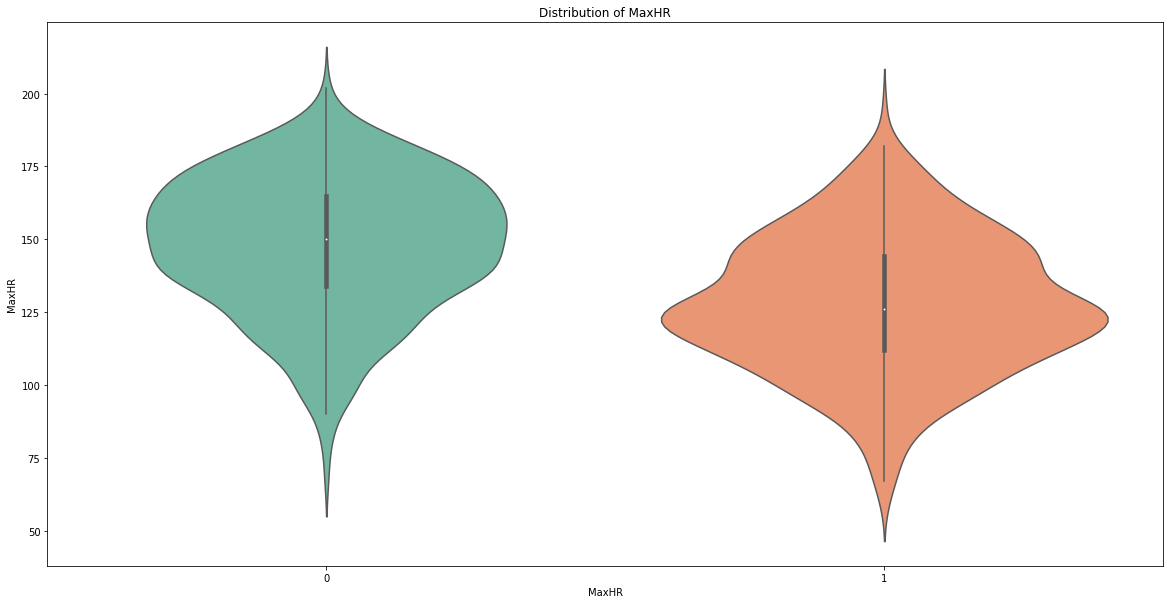

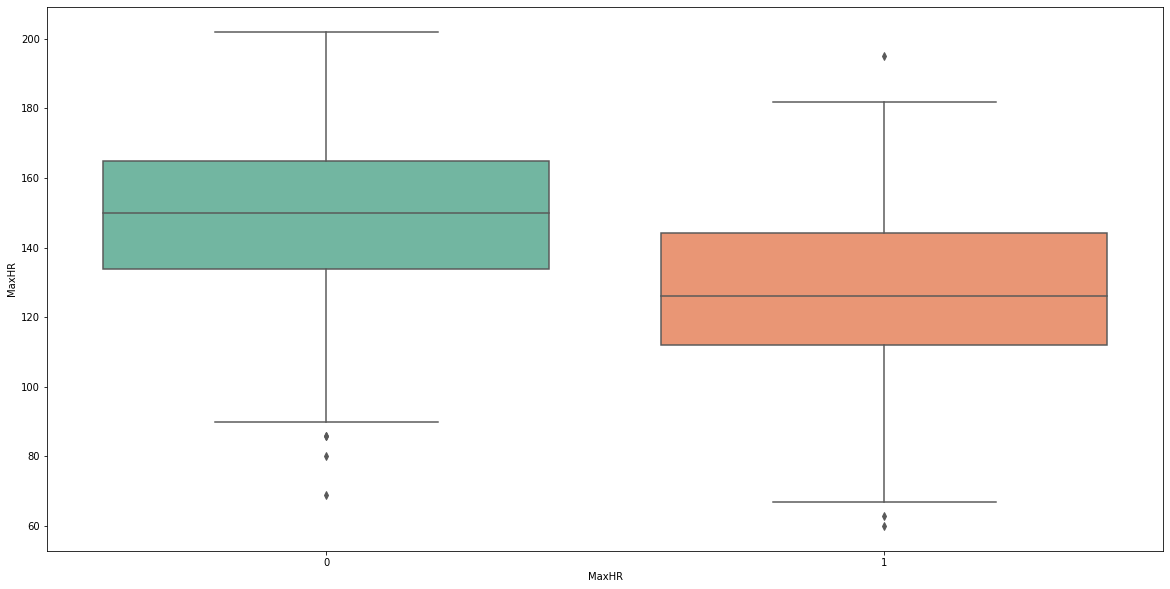

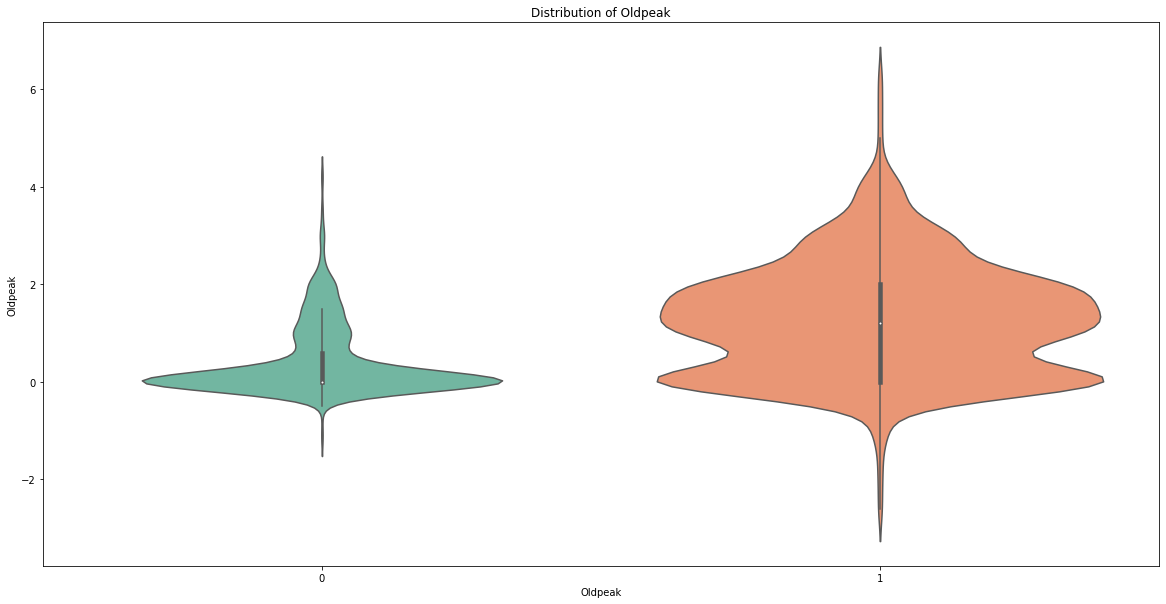

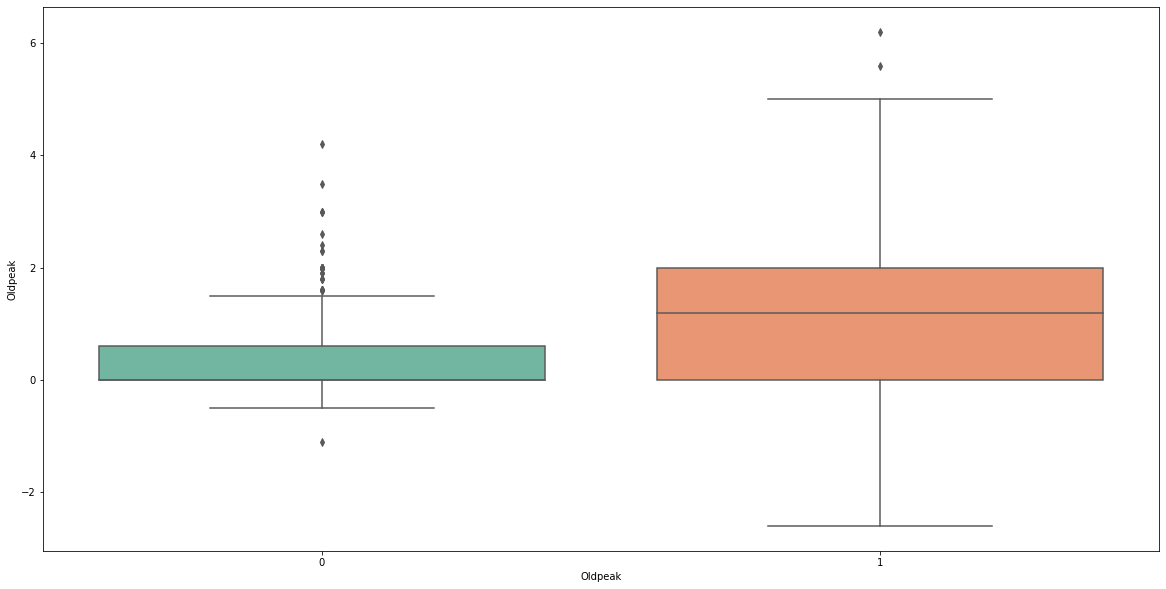

In [31]:
for numerical_feature in numerical_features: 
    distribution_acording_to_target_value(numerical_feature)
    

#### Categorical features: Plots

In [32]:
def categorical_distribution_acording_to_target_value(variable_name):
    plt.figure(figsize=(20, 10))
    plt.title(f"Distribution of {variable_name}")
    ax = sns.countplot(x=f"{variable_name}", hue="HeartDisease", data=data)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=14)
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/distribution_{variable_name}_targetb.png")
    plt.show()
    plt.close()

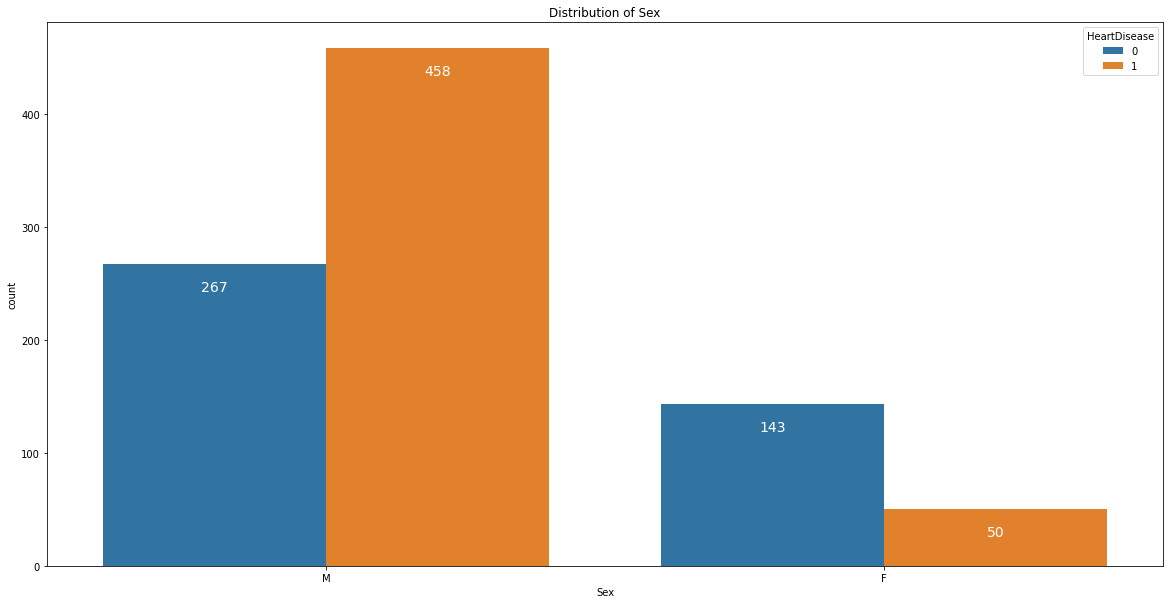

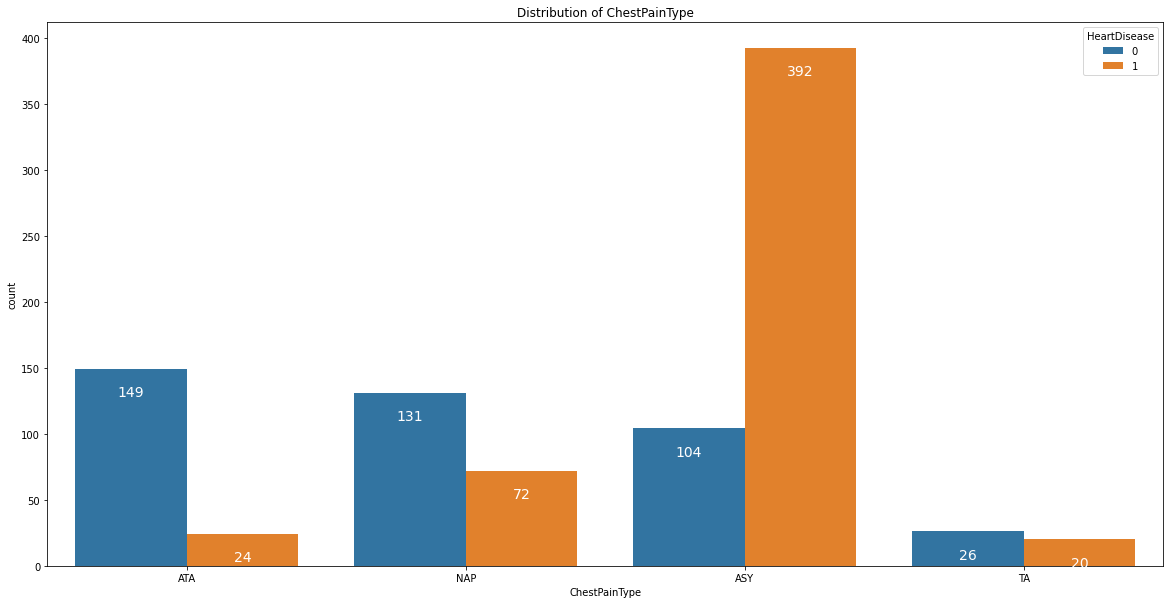

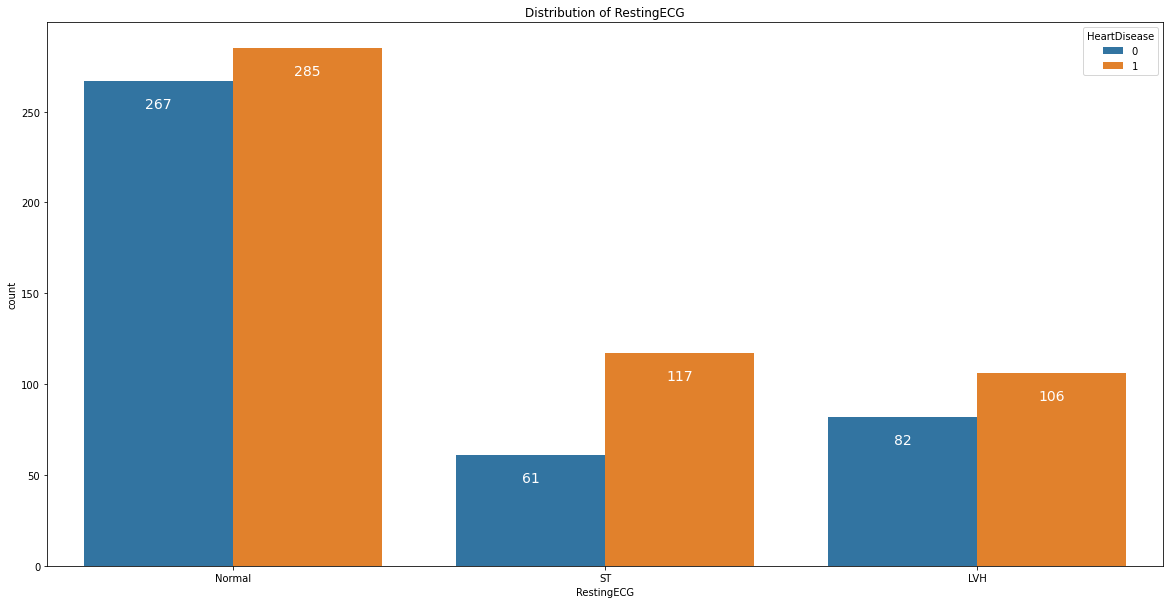

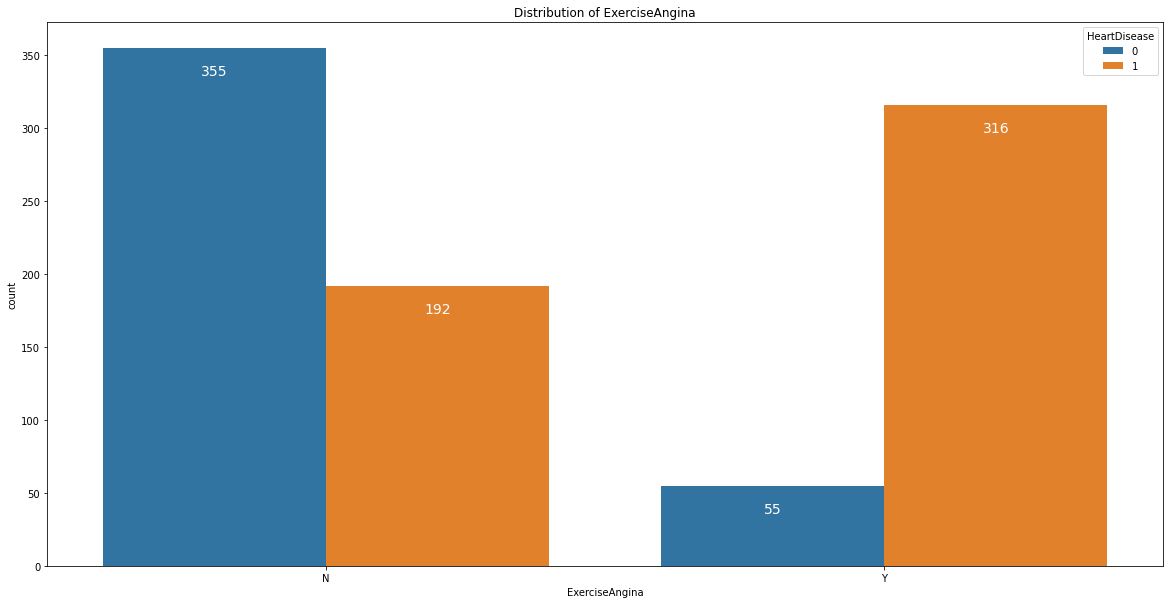

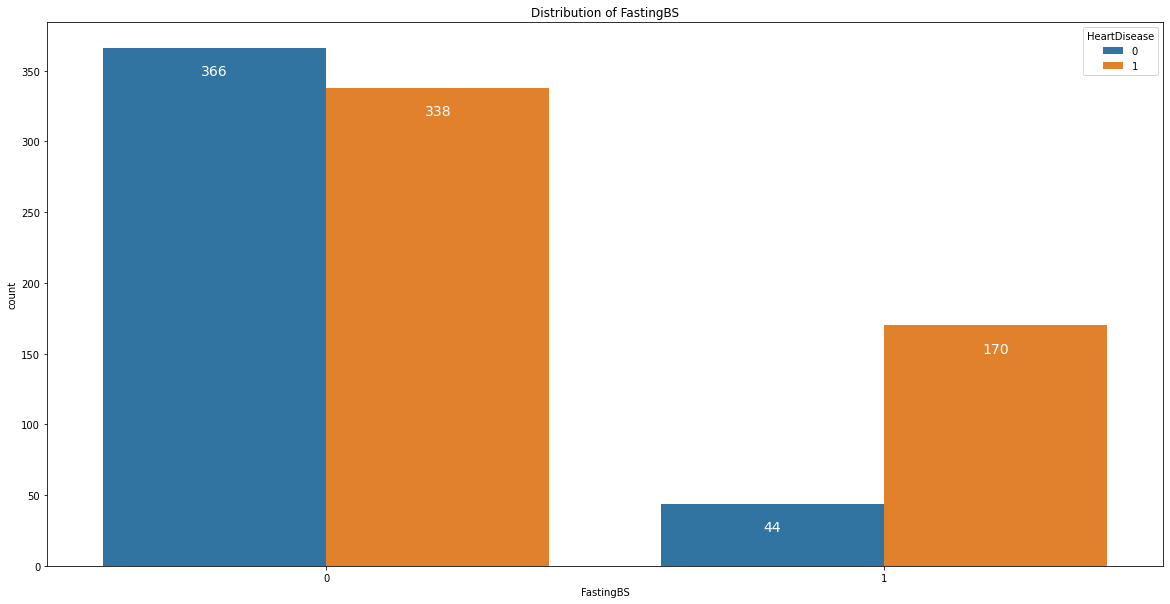

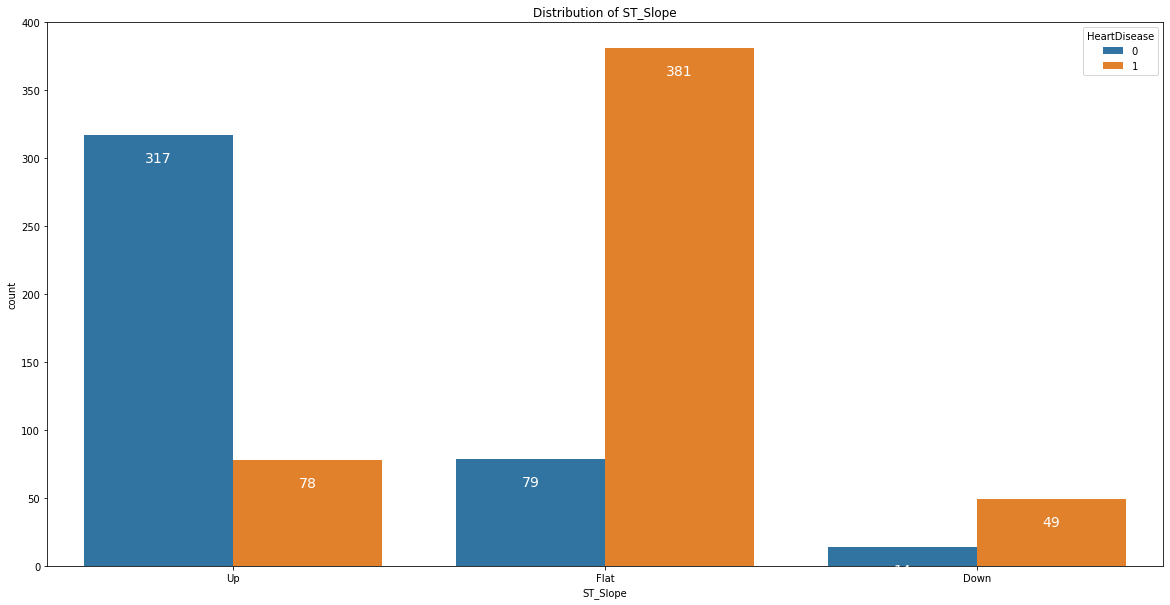

In [33]:
for categorical_feature in categorical_features[:-1]: 
    categorical_distribution_acording_to_target_value(categorical_feature)

#### ANOVA analysis

The idea of this analysis is to see if there is any connection between the target values and the different numerical variables.

In [34]:
for numerical_feauture in numerical_features:
    none_relevant_features = []
    p_value = 0.05
    anova_test = stats.f_oneway(data[f'{numerical_feauture}'][data['HeartDisease'] == 0], data[f'{numerical_feauture}'][data['HeartDisease'] == 1])
    if anova_test[1] > p_value:
        none_relevant_features.append(feature)

#### Chi analysis

The idea of this analysis is to see if there is any connection between the target values and the different categorical variables.

In [35]:
p_value = 0.05
for categorical_feature in categorical_features:
    ct = pd.crosstab(data[f'{categorical_feature}'], data['HeartDisease'], margins=True)
    ct = ct.drop("All", axis=1).drop("All", axis=0)
    obs = np.array(ct.values)
    if stats.chi2_contingency(obs)[0:3][1] > p_value:
        none_relevant_features.append(f'{categorical_feature}')
print(none_relevant_features) 

[]


#### Decistion Tree: Feature understanding

The idea is to train a decision tree to understand what are the variables that affect most the target value, or if any variable does not affect it

In [36]:
# Encoding:
decision_tree = data.copy()

object_cols = decision_tree.loc[:, data.dtypes == 'O']
object_type_columns = [col for col in object_cols.columns]

for column in object_type_columns:
    decision_tree[f'{column}'] = LabelEncoder().fit_transform(decision_tree[f'{column}'])
    
features_for_importance=decision_tree.columns.to_list()
features_for_importance.remove('HeartDisease')

In [37]:
clasifier = DecisionTreeClassifier()
clasifier.fit(decision_tree.loc[:, decision_tree.columns != 'HeartDisease'], decision_tree['HeartDisease'])

DecisionTreeClassifier()

Text(0.5, 0, 'Relative Importance')

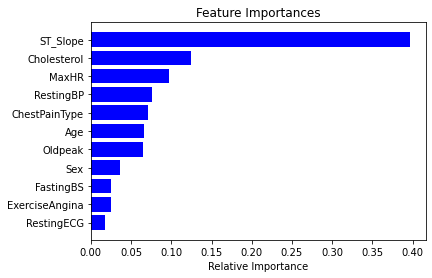

In [38]:
importances = clasifier.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(features_for_importance)[indices])
plt.xlabel('Relative Importance')

#### Correlations

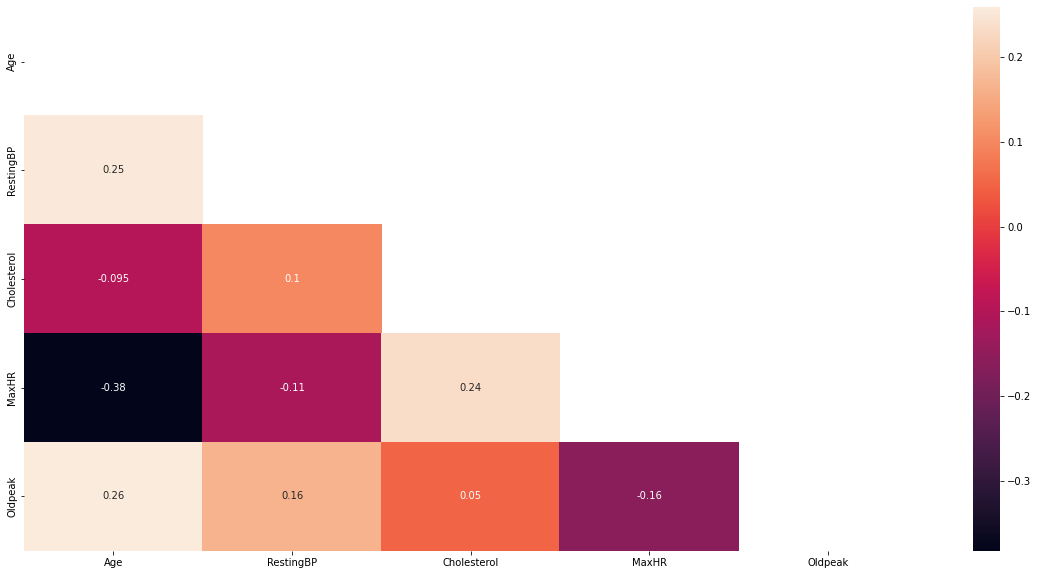

In [39]:
plt.figure(figsize=(20, 10))
matrix = np.triu(data[numerical_features].corr())
sns.heatmap(data[numerical_features].corr(), annot=True, mask=matrix)
plt.show()
plt.close()

In [40]:
data.corr().unstack().sort_values().drop_duplicates().head(10)

HeartDisease  MaxHR         -0.400421
Age           MaxHR         -0.382045
Cholesterol   FastingBS     -0.260974
HeartDisease  Cholesterol   -0.232741
Oldpeak       MaxHR         -0.160691
FastingBS     MaxHR         -0.131438
RestingBP     MaxHR         -0.112135
Age           Cholesterol   -0.095282
Cholesterol   Oldpeak        0.050148
FastingBS     Oldpeak        0.052698
dtype: float64

In [41]:
data.corr().unstack().sort_values().drop_duplicates().tail(10)

HeartDisease  RestingBP       0.107589
Oldpeak       RestingBP       0.164803
FastingBS     Age             0.198039
MaxHR         Cholesterol     0.235792
RestingBP     Age             0.254399
Age           Oldpeak         0.258612
HeartDisease  FastingBS       0.267291
              Age             0.282039
Oldpeak       HeartDisease    0.403951
Age           Age             1.000000
dtype: float64

#### Unsupervised learning for hidden patterns: UMAP

In [42]:
scaler = StandardScaler()

data_clustering = data.copy()

object_cols = data_clustering.loc[:, data_clustering.dtypes == 'O']
object_type_columns = [col for col in object_cols.columns]

for column in object_type_columns:
    data_clustering[f'{column}'] = LabelEncoder().fit_transform(data_clustering[f'{column}'])
data_clustering = scaler.fit_transform(data_clustering.loc[:, data.columns != 'HeartDisease'])

In [43]:
umap_embeding = umap.UMAP(random_state=42).fit_transform(data_clustering)

In [44]:
for n_of_components in range(0,12):
    pca = PCA(n_components=n_of_components)
    pca_embeding = pca.fit_transform(data_clustering)
    print(f'Number of Components :{n_of_components}, {pca.explained_variance_ratio_.sum()}')

Number of Components :0, 0.0
Number of Components :1, 0.25139664590150856
Number of Components :2, 0.3844855433522387
Number of Components :3, 0.4896146744054366
Number of Components :4, 0.580504232757568
Number of Components :5, 0.6596718447968662
Number of Components :6, 0.7366239079232438
Number of Components :7, 0.8099544767246707
Number of Components :8, 0.8667098245270434
Number of Components :9, 0.9173760998918937
Number of Components :10, 0.9629480442797332
Number of Components :11, 1.0


In [45]:
pca = PCA(n_components=2)
pca_embeding = pca.fit_transform(data_clustering)
print(pca.explained_variance_ratio_.sum())

0.3844855433522383


In [46]:
kmeans_true_labels = cluster.KMeans(n_clusters=2).fit_predict(data_clustering)
kmeans_umap_labels = cluster.KMeans(n_clusters=2).fit_predict(umap_embeding
                                                              [:, 0].reshape(-1, 1), umap_embeding[:, 1].reshape(-1, 1))
kmeans_pca_labels = cluster.KMeans(n_clusters=2).fit_predict(pca_embeding[:, 0].reshape(-1, 1), pca_embeding[:, 1].reshape(-1, 1))

In [47]:
def scatter_plot(axis1, axis2, color, title, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.scatter(axis1, axis2, c=color, cmap='Pastel1')
    plt.title(f'{title}')
    plt.xlabel(f'{xlabel}')
    plt.ylabel(f'{ylabel}')
    plt.show()
    plt.close()

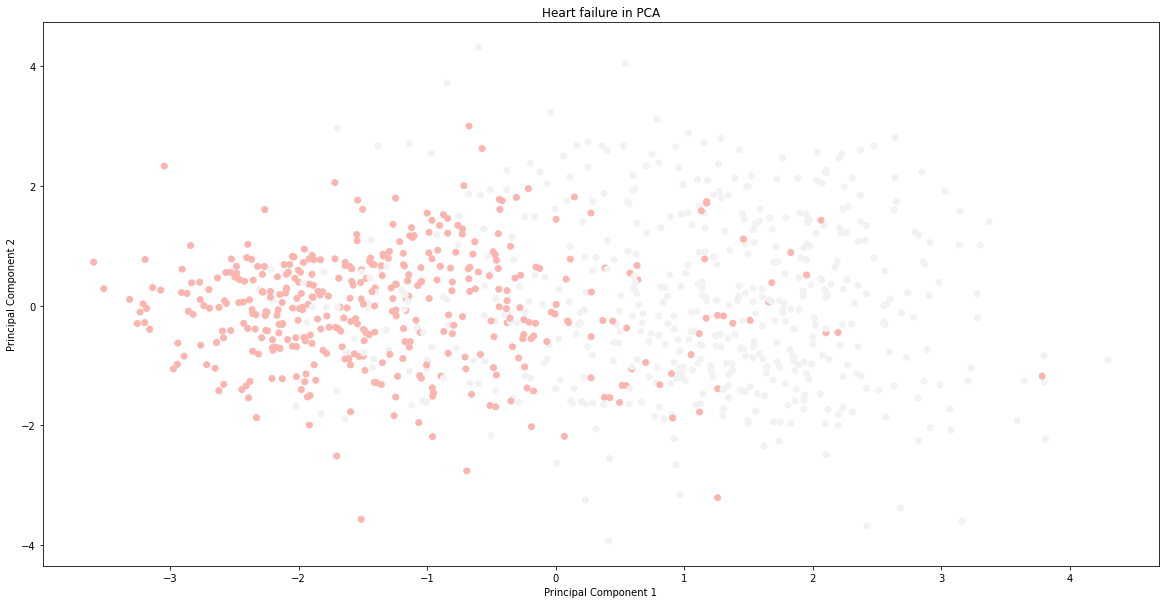

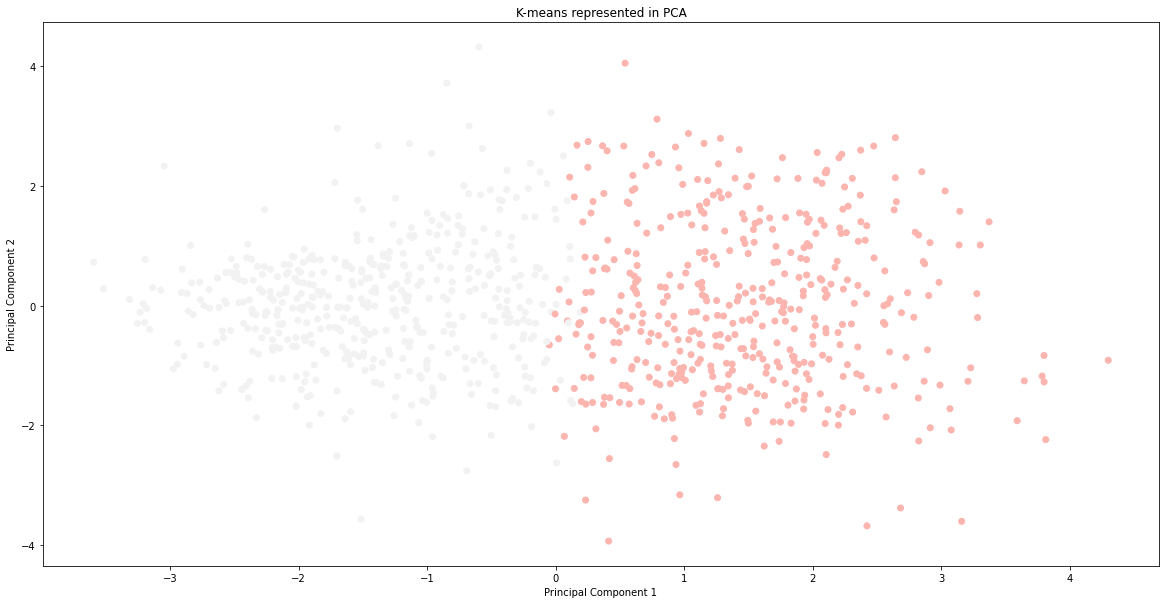

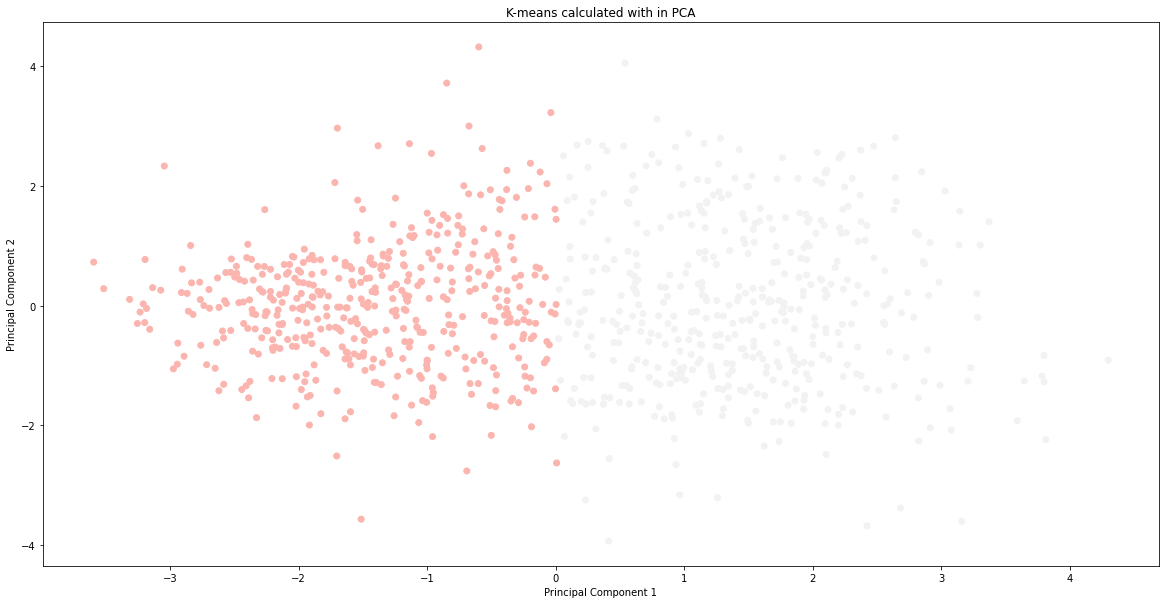

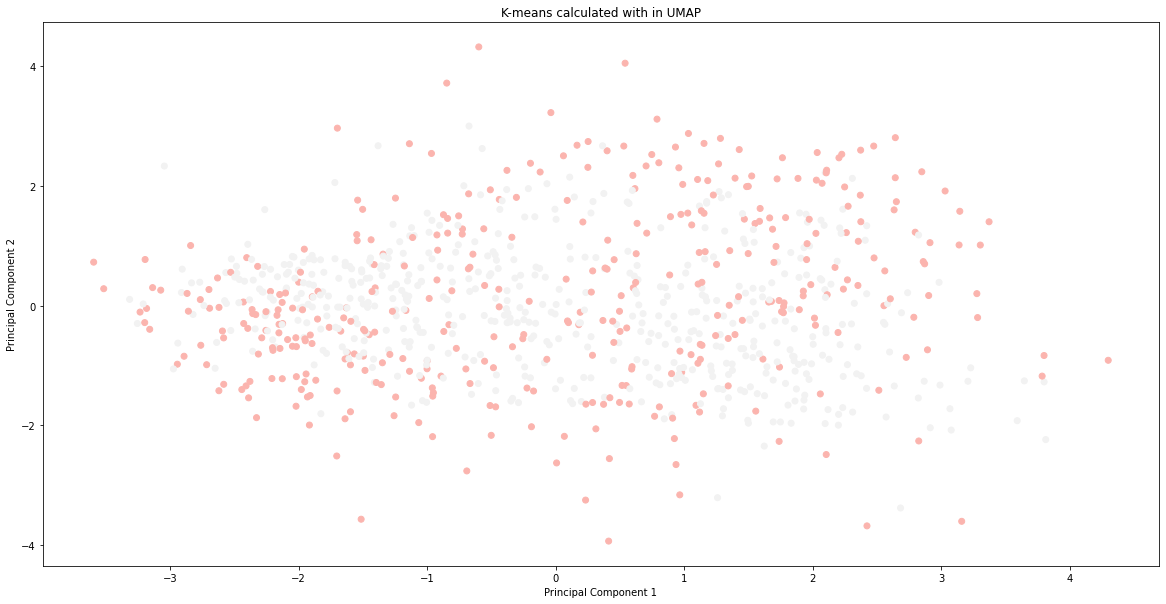

In [48]:
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=data['HeartDisease'],
            title='Heart failure in PCA', 
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=kmeans_true_labels,
            title='K-means represented in PCA',
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=kmeans_pca_labels,
            title='K-means calculated with in PCA',
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=kmeans_umap_labels,
            title='K-means calculated with in UMAP',
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')

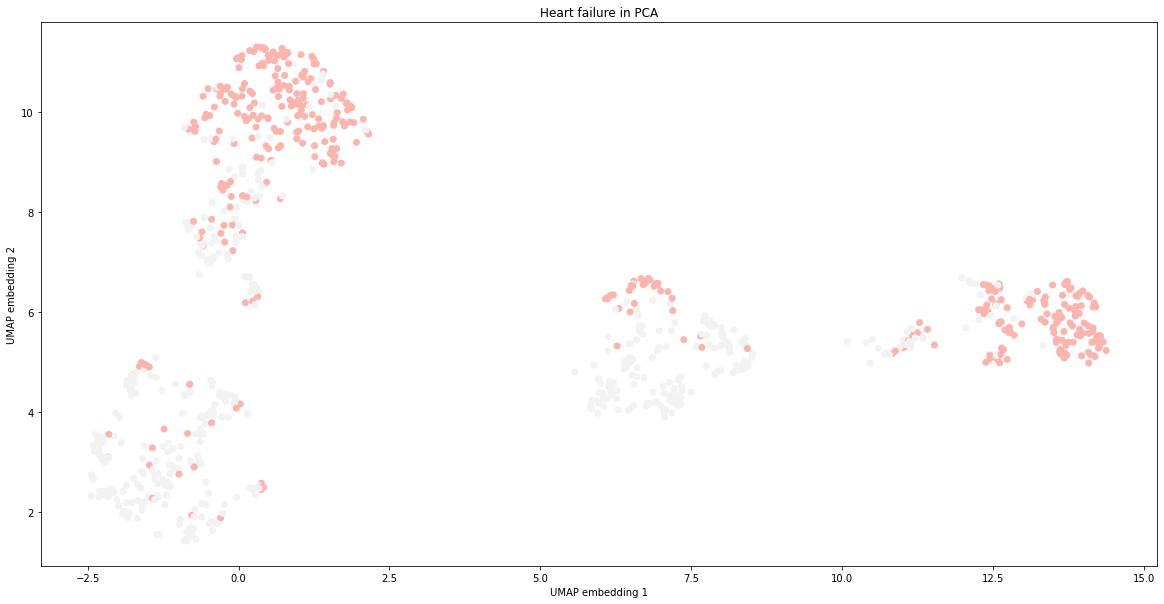

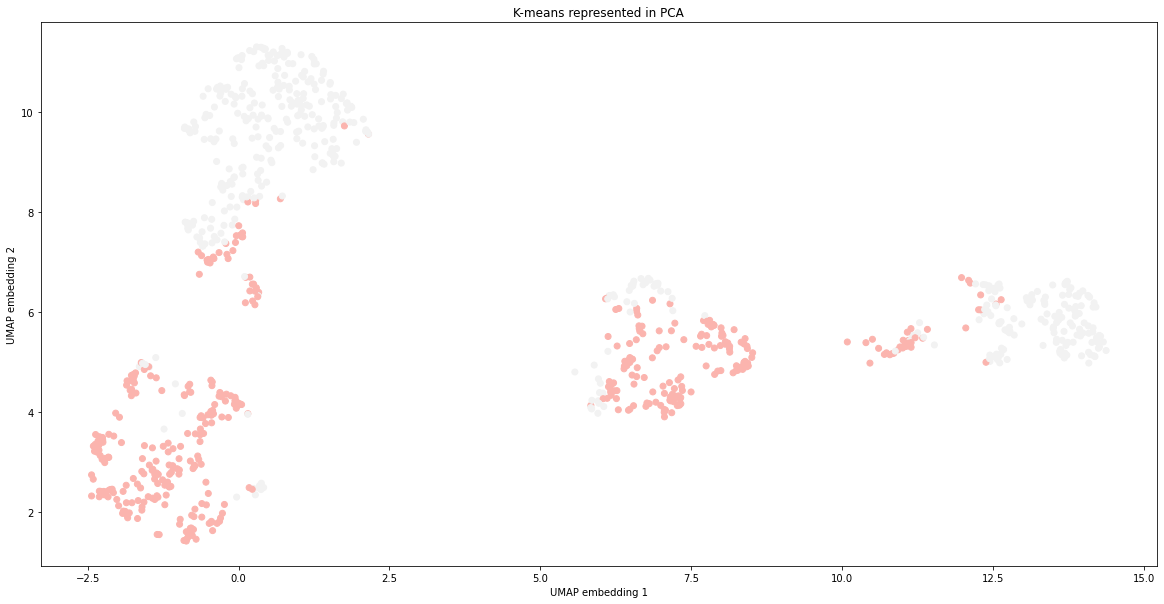

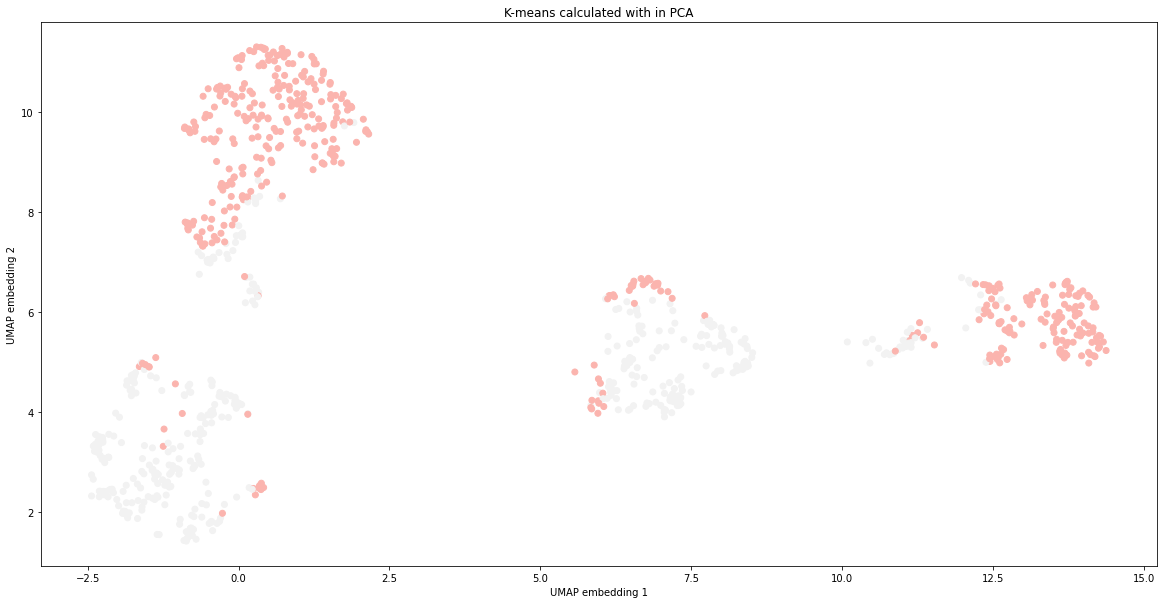

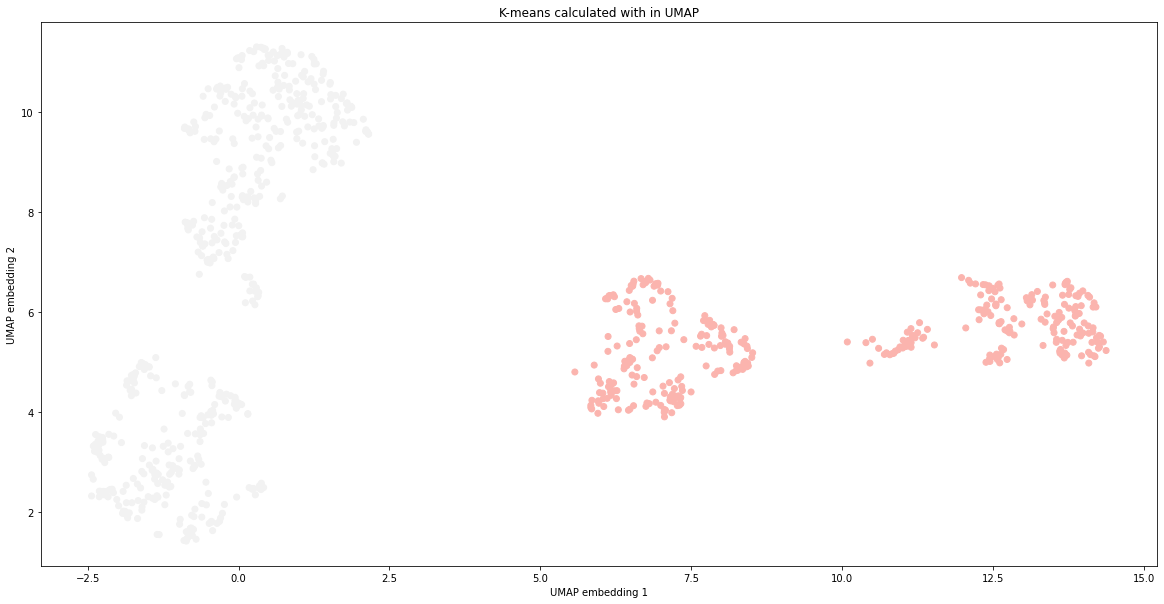

In [49]:
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=data['HeartDisease'],
            title='Heart failure in PCA', 
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=kmeans_true_labels,
            title='K-means represented in PCA',
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=kmeans_pca_labels,
            title='K-means calculated with in PCA',
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=kmeans_umap_labels,
            title='K-means calculated with in UMAP',
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')

In [50]:
def get_results(label, method, method_name):
    """
    df = pd.DataFrame(list(zip(label, method)), columns =['Label', f'{method_name}'])
    print(df)
    print(df.groupby([f'{method_name}']).count())
    print(df.groupby([f'Label', f'{method_name}']))
    """
    print(method_name)
    cm = confusion_matrix(label, method)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

k means


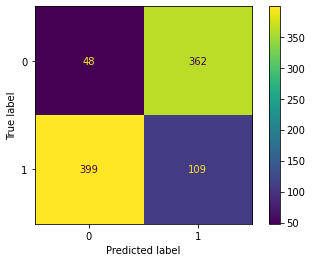

k means PCA


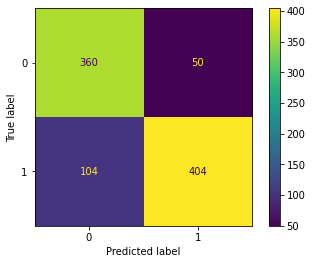

k means UMAP


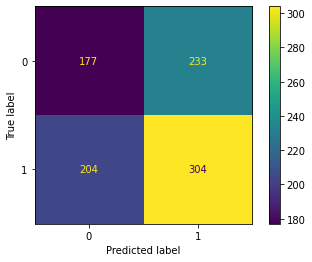

In [51]:
get_results(data['HeartDisease'], kmeans_true_labels, 'k means')
get_results(data['HeartDisease'], kmeans_pca_labels, 'k means PCA')
get_results(data['HeartDisease'], kmeans_umap_labels, 'k means UMAP')

### EDA: Conclusions

More than one dataset has been created, depending on different decissions that have been taken in different phases of the EDA. 


## Modeling

### Feature Engineering

In [52]:
def categorical_variable_encoding(data):
    object_cols = data.loc[:, data.dtypes == 'O']
    object_type_columns = [col for col in object_cols.columns]

    for column in object_type_columns:
        data[f'{column}'] = LabelEncoder().fit_transform(data[f'{column}'])
    return data

In [53]:
def standarizer(X):
    scaler = StandardScaler().fit(X)
    X_transformed = scaler.transform(X)
    return scaler, X_transformed

In [54]:
def normalizer(X):
    scaler = Normalizer().fit(X)
    X_transformed = scaler.transform(X)
    return scaler, X_transformed

### Dataset spliting

In [55]:
def data_spliter(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,train_size=0.8)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,train_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

### Creation of all datasets

In [56]:
datasets = {}

In [106]:
# Dataset 1: No modifications
dataset_1_x = categorical_variable_encoding(dataset_1.drop(['HeartDisease'], axis=1))
scaler_standarizer, dataset_1_x = standarizer(dataset_1_x)
scaler_normalizer, dataset_1_x = normalizer(dataset_1_x)
X_train, y_train, X_val, y_val, X_test, y_test = data_spliter(dataset_1_x, dataset_1['HeartDisease'].values)

datasets.update({'dataset 1': {'description': 'No modifications',
                               'shape': dataset_1.shape,
                               'x_train': X_train, 'y_train': y_train,
                               'x_val': X_val, 'y_val': y_val,
                               'x_test': X_test, 'y_test': y_test}})

unique, counts = np.unique(y_train, return_counts=True)
print(f'Value counts TRAIN{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_val, return_counts=True)
print(f'Value counts VAL{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_test, return_counts=True)
print(f'Value counts TEST{np.asarray((unique, counts)).T}')

# Dataset 2.1: Missing values by statistical method
dataset_2_1_x = categorical_variable_encoding(dataset_2_1.drop(['HeartDisease'], axis=1))
scaler_standarizer, dataset_2_1_x = standarizer(dataset_2_1_x)
scaler_normalizer, dataset_2_1_x = normalizer(dataset_2_1_x)
X_train, y_train, X_val, y_val, X_test, y_test = data_spliter(dataset_2_1_x, dataset_2_1['HeartDisease'].values)

datasets.update({'dataset 2_1': {'description': 'Missing values by statistical method',
                                 'shape': dataset_2_1.shape,
                                 'x_train': X_train, 'y_train': y_train,
                                 'x_val': X_val, 'y_val': y_val,
                                 'x_test': X_test, 'y_test': y_test}})

unique, counts = np.unique(y_train, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_val, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_test, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')

# Dataset 2.2: Missing values by Regression inputation
dataset_2_2_x = categorical_variable_encoding(dataset_2_2.drop(['HeartDisease'], axis=1))
dataset_2_2_x = inpute_via_regression(dataset_2_2_x)
scaler_standarizer, dataset_2_2_x = standarizer(dataset_2_2_x)
scaler_normalizer, dataset_2_2_x = normalizer(dataset_2_2_x)
X_train, y_train, X_val, y_val, X_test, y_test = data_spliter(dataset_2_2_x, dataset_2_2['HeartDisease'].values)

datasets.update({'dataset 2_2': {'description': 'Missing values by Regression inputation',
                                 'shape': dataset_2_2.shape,
                                 'x_train': X_train, 'y_train': y_train,
                                 'x_val': X_val, 'y_val': y_val,
                                 'x_test': X_test, 'y_test': y_test}})

unique, counts = np.unique(y_train, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_val, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_test, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')

# Dataset 3.1: Missing values by statistical method and Outliers

for symetric_distribution_feature in symetric_distribution_features:
    dataset_3_1 = mean_3_std(symetric_distribution_feature, dataset_3_1)
for asymetric_distribution_feature in asymetric_distribution_features:
    dataset_3_1 = iqr(asymetric_distribution_feature, dataset_3_1)
dataset_3_1_x = categorical_variable_encoding(dataset_3_1.drop(['HeartDisease'], axis=1))
scaler_standarizer, dataset_3_1_x = standarizer(dataset_3_1_x)
scaler_normalizer, dataset_3_1_x = normalizer(dataset_3_1_x)
X_train, y_train, X_val, y_val, X_test, y_test = data_spliter(dataset_3_1_x, dataset_3_1['HeartDisease'].values)

datasets.update({'dataset 3_1': {'description': 'Missing values by statistical method and Outliers',
                                 'shape': dataset_3_1.shape,
                                 'x_train': X_train, 'y_train': y_train,
                                 'x_val': X_val, 'y_val': y_val,
                                 'x_test': X_test, 'y_test': y_test}})

unique, counts = np.unique(y_train, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_val, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_test, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')

# Dataset 3.2: Missing values by Regression inputation and Outliers

for symetric_distribution_feature in symetric_distribution_features:
    dataset_3_2 = mean_3_std(symetric_distribution_feature, dataset_3_2)
for asymetric_distribution_feature in asymetric_distribution_features:
    dataset_3_2 = iqr(asymetric_distribution_feature, dataset_3_2)
dataset_3_2_x = categorical_variable_encoding(dataset_3_2.drop(['HeartDisease'], axis=1))
dataset_3_2_x = inpute_via_regression(dataset_3_2_x)
scaler_standarizer, dataset_3_2_x = standarizer(dataset_3_2_x)
scaler_normalizer, dataset_3_2_x = normalizer(dataset_3_2_x)
X_train, y_train, X_val, y_val, X_test, y_test = data_spliter(dataset_3_2_x, dataset_3_2['HeartDisease'].values)

datasets.update({'dataset 3_2': {'description': 'Missing values by Regression inputation and Outliers',
                                 'shape': dataset_3_2.shape,
                                 'x_train': X_train, 'y_train': y_train,
                                 'x_val': X_val, 'y_val': y_val,
                                 'x_test': X_test, 'y_test': y_test}})

unique, counts = np.unique(y_train, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_val, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_test, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')

# Dataset PCA: Missing values by Regression inputation and Outliers + PCA

for symetric_distribution_feature in symetric_distribution_features:
    dataset_3_2 = mean_3_std(symetric_distribution_feature, dataset_3_2)
for asymetric_distribution_feature in asymetric_distribution_features:
    dataset_3_2 = iqr(asymetric_distribution_feature, dataset_3_2)
dataset_3_2_x = categorical_variable_encoding(dataset_3_2.drop(['HeartDisease'], axis=1))
dataset_3_2_x = inpute_via_regression(dataset_3_2_x)
scaler_standarizer, dataset_3_2_x = standarizer(dataset_3_2_x)
scaler_normalizer, dataset_3_2_x = normalizer(dataset_3_2_x)
pca = PCA(n_components=7)
pca_embeding = pca.fit_transform(dataset_3_2_x)
print(f"The explained variance is: {pca.explained_variance_ratio_.sum()}")
X_train, y_train, X_val, y_val, X_test, y_test = data_spliter(pca_embeding, dataset_3_2['HeartDisease'].values)

datasets.update({'dataset PCA': {'description': 'Missing values by Regression inputation and Outliers',
                                 'shape': pca_embeding.shape + (0, 1),
                                 'x_train': X_train, 'y_train': y_train,
                                 'x_val': X_val, 'y_val': y_val,
                                 'x_test': X_test, 'y_test': y_test}})

unique, counts = np.unique(y_train, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_val, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_test, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')

# Dataset UMAP: Missing values by Regression inputation and Outliers + UMAP

for symetric_distribution_feature in symetric_distribution_features:
    dataset_3_2 = mean_3_std(symetric_distribution_feature, dataset_3_2)
for asymetric_distribution_feature in asymetric_distribution_features:
    dataset_3_2 = iqr(asymetric_distribution_feature, dataset_3_2)
dataset_3_2_x = categorical_variable_encoding(dataset_3_2.drop(['HeartDisease'], axis=1))
dataset_3_2_x = inpute_via_regression(dataset_3_2_x)
scaler_standarizer, dataset_3_2_x = standarizer(dataset_3_2_x)
scaler_normalizer, dataset_3_2_x = normalizer(dataset_3_2_x)
umap_embeding = umap.UMAP(random_state=42).fit_transform(dataset_3_2_x)

X_train, y_train, X_val, y_val, X_test, y_test = data_spliter(umap_embeding, dataset_3_2['HeartDisease'].values)

datasets.update({'dataset UMAP': {'description': 'Missing values by Regression inputation and Outliers',
                                 'shape': umap_embeding.shape + (0, 1),
                                 'x_train': X_train, 'y_train': y_train,
                                 'x_val': X_val, 'y_val': y_val,
                                 'x_test': X_test, 'y_test': y_test}})

unique, counts = np.unique(y_train, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_val, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')
unique, counts = np.unique(y_test, return_counts=True)
print(f'Value counts{np.asarray((unique, counts)).T}')


Value counts TRAIN[[  0 327]
 [  1 407]]
Value counts VAL[[ 0 42]
 [ 1 50]]
Value counts TEST[[ 0 41]
 [ 1 51]]
Value counts[[  0 335]
 [  1 399]]
Value counts[[ 0 26]
 [ 1 66]]
Value counts[[ 0 49]
 [ 1 43]]
Value counts[[  0 329]
 [  1 405]]
Value counts[[ 0 41]
 [ 1 51]]
Value counts[[ 0 40]
 [ 1 52]]
Variable Age: Lower outliers [], Upper outliers [], boundaries 24.95718570986145, 81.60691685424112
Variable Cholesterol: Lower outliers [], Upper outliers [518], boundaries -123.10080984614649, 516.9399706853073
Variable MaxHR: Lower outliers [], Upper outliers [], boundaries 61.3028551811727, 213.15688810937573
Variable RestingBP: Lower outliers [], 0, Upper outliers [], 0, boundaries 90.0, 170.0
Variable Oldpeak: Lower outliers [], 0, Upper outliers [], 0, boundaries -2.25, 3.75
Value counts[[  0 311]
 [  1 374]]
Value counts[[ 0 43]
 [ 1 43]]
Value counts[[ 0 42]
 [ 1 44]]
Variable Age: Lower outliers [], Upper outliers [], boundaries 24.94100880614386, 81.62375198732173
Variable C

In [58]:
datasets.keys()

dict_keys(['dataset 1', 'dataset 2_1', 'dataset 2_2', 'dataset 3_1', 'dataset 3_2', 'dataset PCA', 'dataset UMAP'])

### Hyperparameter tuning

The idea behind this hyperparameter tunning is to work with the validation and traning dataset to ensure that the hyperparameters of this algorithms are best suited.

Overfitting and underfitting will also be checked by checking the difference in metrics between the training and validation results. 

In [59]:
def load_best_hyperparameters(algorithm, search_method):
    path_to_file = pathlib.Path(f'{base_path}/modeling/hyperparamters/{algorithm}_{search_method}.pickle')
    if path_to_file.is_file():
        with open(str(path_to_file), 'rb') as handle:
            best_hyperparameters = pickle.load(handle)
    else:
        best_hyperparameters = {}
    return best_hyperparameters

In [60]:
def save_best_hyperparameters(hyperparameters, algorithm, search_method):
    path_to_file = pathlib.Path(f'{base_path}/modeling/hyperparamters/{algorithm}_{search_method}.pickle')
    with open(str(path_to_file), 'wb') as handle:
        best_hyperparameters = pickle.dump(hyperparameters, handle)

In [61]:
def tune_hyperparameters(X, y, algorithm='None', save_tuning=True, load_tunining=False, search_method='grid_search', model=GaussianNB(), parameter_grid={}):
    if not load_tunining:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        if search_method == 'grid_search':
            grid_search = GridSearchCV(estimator=model,
                                       param_grid=parameter_grid, n_jobs=-1, cv=cv,
                                       scoring='f1',error_score=0)
            results = grid_search.fit(X, y)
        elif search_method == 'random_search':
            random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=parameter_grid, n_jobs=-1, cv=cv,
                                       scoring='f1',error_score=0)
            results = random_search.fit(X, y)
        print(f"Best F1 for hyperparameter tuning: {results.best_score_}")
        result = results.best_params_
        if save_tuning: # save the results
            save_best_hyperparameters(result, algorithm, search_method)
    else:
        result = load_best_hyperparameters(algorithm, search_method)
    return result

In [62]:
overfitting_threshold = 0.15

#### KNN

In [63]:
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [64]:
n_neighbors = range(1, 5, 1)  # Number of Neighbours
weights = ['uniform', 'distance']  # Weight function used in prediction
p = np.linspace(1 ,2 ,11) # Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance 
knn_params_random = dict(n_neighbors=n_neighbors,weights=weights,p=p)

for dataset in datasets.keys():
    print(dataset)
    start_random_search = time.time()
    # The random search is only performed for one dataset, while the grid search picks the best hyperparemters per dataset
    knn_best_hyperparameters = tune_hyperparameters(X=datasets.get('dataset 1').get('x_train'),
                                                    y=datasets.get('dataset 1').get('y_train'),
                                                    algorithm='knn',
                                                    save_tuning=True,
                                                    load_tunining=False,
                                                    search_method='random_search',
                                                    model=KNeighborsClassifier(),
                                                    parameter_grid=knn_params_random)
    print(f'Hyperparameter for KNN are Random Search is {knn_best_hyperparameters}')
    end_random_search = time.time()

    model = None
    lower_boundarie = range(knn_best_hyperparameters.get('n_neighbors')-3, knn_best_hyperparameters.get('n_neighbors'), 1)
    upper_boundarie = range(knn_best_hyperparameters.get('n_neighbors'), knn_best_hyperparameters.get('n_neighbors') + 1, 1)
    n_neighbors = list(lower_boundarie) + list(upper_boundarie)
    knn_params_grid = dict(n_neighbors=n_neighbors)
    start_grid_search = time.time()
    knn_best_hyperparameters_grid = tune_hyperparameters(X=datasets.get(f'{dataset}').get('x_train'),
                                                y=datasets.get(f'{dataset}').get('y_train'),
                                                algorithm='knn',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=KNeighborsClassifier(),
                                                parameter_grid=knn_params_grid)
    end_grid_search = time.time()

    model = KNeighborsClassifier(weights=knn_best_hyperparameters.get('weights'),
                                 p=knn_best_hyperparameters.get('p'),
                                 n_neighbors=knn_best_hyperparameters_grid.get('n_neighbors'))
    model.fit(datasets.get(f'{dataset}').get('x_train'), datasets.get(f'{dataset}').get('y_train'))
    train_results = model.predict(datasets.get(f'{dataset}').get('x_train'))
    validation_results = model.predict(datasets.get(f'{dataset}').get('x_val'))
    test_results = model.predict(datasets.get(f'{dataset}').get('x_test'))
    test_probability_results = model.predict_proba(datasets.get(f'{dataset}').get('x_test'))
    
    train_f1 = f1_score(datasets.get(f'{dataset}').get('y_train'), train_results)
    validation_f1 = f1_score(datasets.get(f'{dataset}').get('y_val'), validation_results)
    test_f1 = f1_score(datasets.get(f'{dataset}').get('y_test'), test_results)
    
    fpr, tpr, thresholds = roc_curve(datasets.get(f'{dataset}').get('y_test'), test_probability_results[:, 1], pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(datasets.get(f'{dataset}').get('y_test'), test_probability_results)
        
    datasets.get(f'{dataset}').update({'knn': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'random_search_time': end_random_search - start_random_search,
                                               'grid_search_time': end_grid_search - start_grid_search,
                                               'total_time': (end_random_search - start_random_search) + (end_grid_search - start_grid_search), 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    print(f'F1, Train results: {train_f1}, Validation results: {validation_f1}, Test results: {test_f1},  Overfitting: {train_f1 - validation_f1 >= overfitting_threshold}')

dataset 1
Best F1 for hyperparameter tuning: 0.8669151786130856
Hyperparameter for KNN are Random Search is {'weights': 'distance', 'p': 1.6, 'n_neighbors': 3}
Best F1 for hyperparameter tuning: 0.8662298592738035
F1, Train results: 1.0, Validation results: 0.8785046728971962, Test results: 0.8571428571428572,  Overfitting: False
dataset 2_1
Best F1 for hyperparameter tuning: 0.8669151786130856
Hyperparameter for KNN are Random Search is {'weights': 'distance', 'p': 1.6, 'n_neighbors': 3}
Best F1 for hyperparameter tuning: 0.8448659875657458
F1, Train results: 1.0, Validation results: 0.8260869565217391, Test results: 0.9310344827586206,  Overfitting: True
dataset 2_2
Best F1 for hyperparameter tuning: 0.8702300421800017
Hyperparameter for KNN are Random Search is {'weights': 'uniform', 'p': 1.7000000000000002, 'n_neighbors': 3}
Best F1 for hyperparameter tuning: 0.8583197445798185
F1, Train results: 0.9140722291407224, Validation results: 0.8807339449541284, Test results: 0.8380952380

#### Logistic Regression

In [65]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
lr_grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=[1000])

lr_best_hyperparameters = tune_hyperparameters(X=datasets.get('dataset 1').get('x_train'),
                                                y=decision_tree['HeartDisease'],
                                                algorithm='lr',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=LogisticRegression(),
                                                parameter_grid=lr_grid)dd
print(f'Hyperparameter for Logistic Regression are {lr_best_hyperparameters}')

In [66]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2', 'l1', 'none']
c_values = [100, 50, 10, 1] # 0.5, 0.1, 0.01
lr_params_random = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=[1000])

for dataset in datasets.keys():
    
    start_random_search = time.time()
    # The random search is only performed for one dataset, while the grid search picks the best hyperparemters per dataset
    lr_best_hyperparameters = tune_hyperparameters(X=datasets.get('dataset 1').get('x_train'),
                                                    y=datasets.get('dataset 1').get('y_train'),
                                                    algorithm='lr',
                                                    save_tuning=True,
                                                    load_tunining=False,
                                                    search_method='random_search',
                                                    model=LogisticRegression(),
                                                    parameter_grid=lr_params_random)
    print(f'Hyperparameter for LR are Random Search is {lr_best_hyperparameters}')
    end_random_search = time.time()


    print(dataset)
    model = None
    lower_boundarie = range(lr_best_hyperparameters.get('C')-10, lr_best_hyperparameters.get('C'), 10)
    upper_boundarie = range(lr_best_hyperparameters.get('C'), lr_best_hyperparameters.get('C') + 10, 10)
    c_values = list(lower_boundarie) + list(upper_boundarie)
    lr_params_grid = dict(C=c_values)
    start_grid_search = time.time()
    lr_best_hyperparameters_grid = tune_hyperparameters(X=datasets.get(f'{dataset}').get('x_train'),
                                                y=datasets.get(f'{dataset}').get('y_train'),
                                                algorithm='lr',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=LogisticRegression(),
                                                parameter_grid=lr_params_grid)
    end_grid_search = time.time()
    model = LogisticRegression(solver=lr_best_hyperparameters.get('solver'),
                               penalty=lr_best_hyperparameters.get('penalty'),
                               C=lr_best_hyperparameters_grid.get('C'))

    model.fit(datasets.get(f'{dataset}').get('x_train'), datasets.get(f'{dataset}').get('y_train'))
    train_results = model.predict(datasets.get(f'{dataset}').get('x_train'))
    validation_results = model.predict(datasets.get(f'{dataset}').get('x_val'))
    test_results = model.predict(datasets.get(f'{dataset}').get('x_test'))
    test_probability_results = model.predict_proba(datasets.get(f'{dataset}').get('x_test'))
    
    train_f1 = f1_score(datasets.get(f'{dataset}').get('y_train'), train_results)
    validation_f1 = f1_score(datasets.get(f'{dataset}').get('y_val'), validation_results)
    test_f1 = f1_score(datasets.get(f'{dataset}').get('y_test'), test_results)
    
    fpr, tpr, thresholds = roc_curve(datasets.get(f'{dataset}').get('y_test'), test_probability_results[:, 1], pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(datasets.get(f'{dataset}').get('y_test'), test_probability_results)
        
    datasets.get(f'{dataset}').update({'lr': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'random_search_time': end_random_search - start_random_search,
                                               'grid_search_time': end_grid_search - start_grid_search,
                                               'total_time': (end_random_search - start_random_search) + (end_grid_search - start_grid_search), 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    print(f'F1, Train results: {train_f1}, Validation results: {validation_f1}, Test results: {test_f1},  Overfitting: {train_f1 - validation_f1 >= overfitting_threshold}')


Best F1 for hyperparameter tuning: 0.8701490409642737
Hyperparameter for LR are Random Search is {'solver': 'lbfgs', 'penalty': 'none', 'max_iter': 1000, 'C': 1}
dataset 1
Best F1 for hyperparameter tuning: 0.8688990130929359
F1, Train results: 0.875912408759124, Validation results: 0.9174311926605504, Test results: 0.8260869565217391,  Overfitting: False


Setting penalty='none' will ignore the C and l1_ratio parameters


Best F1 for hyperparameter tuning: 0.8701490409642737
Hyperparameter for LR are Random Search is {'solver': 'lbfgs', 'penalty': 'none', 'max_iter': 1000, 'C': 50}
dataset 2_1
Best F1 for hyperparameter tuning: 0.8605642659083118
F1, Train results: 0.8700980392156863, Validation results: 0.853932584269663, Test results: 0.9243697478991597,  Overfitting: False


Setting penalty='none' will ignore the C and l1_ratio parameters


Best F1 for hyperparameter tuning: 0.8727031823487136
Hyperparameter for LR are Random Search is {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000, 'C': 1}
dataset 2_2
Best F1 for hyperparameter tuning: 0.8603685007586691
F1, Train results: 0.8635235732009925, Validation results: 0.8679245283018868, Test results: 0.8737864077669903,  Overfitting: False
Best F1 for hyperparameter tuning: 0.8727031823487136
Hyperparameter for LR are Random Search is {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000, 'C': 1}
dataset 3_1
Best F1 for hyperparameter tuning: 0.8526430428740729
F1, Train results: 0.8610354223433242, Validation results: 0.9245283018867925, Test results: 0.8666666666666666,  Overfitting: False
Best F1 for hyperparameter tuning: 0.8727031823487136
Hyperparameter for LR are Random Search is {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000, 'C': 1}
dataset 3_2
Best F1 for hyperparameter tuning: 0.8726780963876457
F1, Train results: 0.8818897637795274, Valid

#### SVC

In [67]:
SVC().get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [68]:
kernel = ['poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']
c_values = [100, 50, 10, 1] # 0.5, 0.1, 0.01
svc_params_random = dict(kernel=kernel, gamma=gamma, C=c_values, max_iter=[1000])

for dataset in datasets.keys():
    print(f"------- {dataset} ----------")
    start_random_search = time.time()
    # The random search is only performed for one dataset, while the grid search picks the best hyperparemters per dataset
    svc_best_hyperparameters = tune_hyperparameters(X=datasets.get('dataset 1').get('x_train'),
                                                    y=datasets.get('dataset 1').get('y_train'),
                                                    algorithm='svc',
                                                    save_tuning=True,
                                                    load_tunining=False,
                                                    search_method='random_search',
                                                    model=SVC(),
                                                    parameter_grid=svc_params_random)
    print(f'Hyperparameter for SVC are Random Search is {svc_best_hyperparameters}')
    end_random_search = time.time()

    model = None
    lower_boundarie = range(svc_best_hyperparameters.get('C')-10, svc_best_hyperparameters.get('C'), 10)
    upper_boundarie = range(svc_best_hyperparameters.get('C'), svc_best_hyperparameters.get('C') + 10, 10)
    c_values = list(lower_boundarie) + list(upper_boundarie)
    svc_params_grid = dict(C=c_values)
    start_grid_search = time.time()
    svc_best_hyperparameters_grid = tune_hyperparameters(X=datasets.get(f'{dataset}').get('x_train'),
                                                y=datasets.get(f'{dataset}').get('y_train'),
                                                algorithm='svc',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=SVC(),
                                                parameter_grid=svc_params_grid)
    end_grid_search = time.time()
    model = SVC(kernel=svc_best_hyperparameters.get('kernel'),
                gamma=svc_best_hyperparameters.get('gamma'),
                C=svc_best_hyperparameters_grid.get('C'), probability=True)
    model.fit(datasets.get(f'{dataset}').get('x_train'), datasets.get(f'{dataset}').get('y_train'))
    train_results = model.predict(datasets.get(f'{dataset}').get('x_train'))
    validation_results = model.predict(datasets.get(f'{dataset}').get('x_val'))
    test_results = model.predict(datasets.get(f'{dataset}').get('x_test'))
    test_probability_results = model.predict_proba(datasets.get(f'{dataset}').get('x_test'))
    
    train_f1 = f1_score(datasets.get(f'{dataset}').get('y_train'), train_results)
    validation_f1 = f1_score(datasets.get(f'{dataset}').get('y_val'), validation_results)
    test_f1 = f1_score(datasets.get(f'{dataset}').get('y_test'), test_results)
    
    fpr, tpr, thresholds = roc_curve(datasets.get(f'{dataset}').get('y_test'), test_probability_results[:, 1], pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(datasets.get(f'{dataset}').get('y_test'), test_probability_results)
        
    datasets.get(f'{dataset}').update({'svc': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'random_search_time': end_random_search - start_random_search,
                                               'grid_search_time': end_grid_search - start_grid_search,
                                               'total_time': (end_random_search - start_random_search) + (end_grid_search - start_grid_search), 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    print(f'F1, Train results: {train_f1}, Validation results: {validation_f1}, Test results: {test_f1},  Overfitting: {train_f1 - validation_f1 >= overfitting_threshold}')


------- dataset 1 ----------


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Best F1 for hyperparameter tuning: 0.8789687908370063
Hyperparameter for SVC are Random Search is {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 'auto', 'C': 100}
Best F1 for hyperparameter tuning: 0.8305369513596684
F1, Train results: 0.9172749391727495, Validation results: 0.8990825688073394, Test results: 0.875,  Overfitting: False
------- dataset 2_1 ----------
Best F1 for hyperparameter tuning: 0.8853462002529556
Hyperparameter for SVC are Random Search is {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
Best F1 for hyperparameter tuning: 0.8809336991744938
F1, Train results: 0.9123649459783914, Validation results: 0.8351648351648352, Test results: 0.9243697478991597,  Overfitting: False
------- dataset 2_2 ----------


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Best F1 for hyperparameter tuning: 0.8801923966866089
Hyperparameter for SVC are Random Search is {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 'auto', 'C': 50}
Best F1 for hyperparameter tuning: 0.8097856509214558
F1, Train results: 0.896969696969697, Validation results: 0.8909090909090909, Test results: 0.8932038834951458,  Overfitting: False
------- dataset 3_1 ----------


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Best F1 for hyperparameter tuning: 0.8789687908370063
Hyperparameter for SVC are Random Search is {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 'auto', 'C': 100}
Best F1 for hyperparameter tuning: 0.8139141088503529
F1, Train results: 0.901749663526245, Validation results: 0.9514563106796117, Test results: 0.8602150537634409,  Overfitting: False
------- dataset 3_2 ----------
Best F1 for hyperparameter tuning: 0.8853462002529556
Hyperparameter for SVC are Random Search is {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
Best F1 for hyperparameter tuning: 0.8888672192110502
F1, Train results: 0.9238709677419354, Validation results: 0.860759493670886, Test results: 0.8541666666666666,  Overfitting: False
------- dataset PCA ----------
Best F1 for hyperparameter tuning: 0.8853462002529556
Hyperparameter for SVC are Random Search is {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
Best F1 for hyperparameter tuning: 0.8612052281888244
F1, Train results: 0.8985115020

#### Random Forest

In [69]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [70]:
n_estimators = [3, 6, 9, 20, 30, 40, 50, 75, 100]
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2']
max_depth = [10, 5, 2, None]
bootstrap = [True, False]
rfc_params_random = dict(n_estimators=n_estimators, max_features=max_features, criterion=criterion, max_depth=max_depth, bootstrap=bootstrap)

for dataset in datasets.keys():

    print(f"------- {dataset} ----------")
    start_random_search = time.time()
    # The random search is only performed for one dataset, while the grid search picks the best hyperparemters per dataset
    rfc_best_hyperparameters = tune_hyperparameters(X=datasets.get('dataset 1').get('x_train'),
                                                    y=datasets.get('dataset 1').get('y_train'),
                                                    algorithm='rfc',
                                                    save_tuning=True,
                                                    load_tunining=False,
                                                    search_method='random_search',
                                                    model=RandomForestClassifier(),
                                                    parameter_grid=rfc_params_random)
    print(f'Hyperparameter for RFC are Random Search is {rfc_best_hyperparameters}')
    end_random_search = time.time()

    model = None
    lower_boundarie = range(rfc_best_hyperparameters.get('n_estimators')-5, rfc_best_hyperparameters.get('n_estimators'), 5)
    upper_boundarie = range(rfc_best_hyperparameters.get('n_estimators'), rfc_best_hyperparameters.get('n_estimators') + 5, 5)
    n_estimators = list(lower_boundarie) + list(upper_boundarie)
    rfc_params_grid = dict(n_estimators=n_estimators)
    start_grid_search = time.time()
    rfc_best_hyperparameters_grid = tune_hyperparameters(X=datasets.get(f'{dataset}').get('x_train'),
                                                y=datasets.get(f'{dataset}').get('y_train'),
                                                algorithm='rfc',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=RandomForestClassifier(),
                                                parameter_grid=rfc_params_grid)
    end_grid_search = time.time()
    model = RandomForestClassifier(n_estimators=rfc_best_hyperparameters_grid.get('n_estimators'),
                criterion=rfc_best_hyperparameters.get('criterion'),
                max_features=rfc_best_hyperparameters.get('max_features'),
                max_depth=rfc_best_hyperparameters.get('max_depth'),
                bootstrap=rfc_best_hyperparameters.get('bootstrap')
               )
    model.fit(datasets.get(f'{dataset}').get('x_train'), datasets.get(f'{dataset}').get('y_train'))
    train_results = model.predict(datasets.get(f'{dataset}').get('x_train'))
    validation_results = model.predict(datasets.get(f'{dataset}').get('x_val'))
    test_results = model.predict(datasets.get(f'{dataset}').get('x_test'))
    test_probability_results = model.predict_proba(datasets.get(f'{dataset}').get('x_test'))
    
    train_f1 = f1_score(datasets.get(f'{dataset}').get('y_train'), train_results)
    validation_f1 = f1_score(datasets.get(f'{dataset}').get('y_val'), validation_results)
    test_f1 = f1_score(datasets.get(f'{dataset}').get('y_test'), test_results)
    
    fpr, tpr, thresholds = roc_curve(datasets.get(f'{dataset}').get('y_test'), test_probability_results[:, 1], pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(datasets.get(f'{dataset}').get('y_test'), test_probability_results)
        
    datasets.get(f'{dataset}').update({'rfc': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'random_search_time': end_random_search - start_random_search,
                                               'grid_search_time': end_grid_search - start_grid_search,
                                               'total_time': (end_random_search - start_random_search) + (end_grid_search - start_grid_search), 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    print(f'F1, Train results: {train_f1}, Validation results: {validation_f1}, Test results: {test_f1},  Overfitting: {train_f1 - validation_f1 >= overfitting_threshold}')


------- dataset 1 ----------
Best F1 for hyperparameter tuning: 0.873547300319878
Hyperparameter for RFC are Random Search is {'n_estimators': 30, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
Best F1 for hyperparameter tuning: 0.866258875270591
F1, Train results: 0.9390243902439024, Validation results: 0.8679245283018867, Test results: 0.8865979381443299,  Overfitting: False
------- dataset 2_1 ----------
Best F1 for hyperparameter tuning: 0.874616603306892
Hyperparameter for RFC are Random Search is {'n_estimators': 30, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
Best F1 for hyperparameter tuning: 0.8734169322575439
F1, Train results: 0.9189842805320435, Validation results: 0.851063829787234, Test results: 0.9152542372881356,  Overfitting: False
------- dataset 2_2 ----------
Best F1 for hyperparameter tuning: 0.8733071346129628
Hyperparameter for RFC are Random Search is {'n_estimators': 100, 'max_features': '

#### XGBoost

In [71]:
xgb.XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [72]:
max_depth = [3, 5, 10] #  [3, 5, 6, 10, 15, 20]
learning_rate = [0.01, 0.1] #  [0.01, 0.1, 0.2, 0.3]
subsample = [0.5] #  np.arange(0.5, 1.0, 0.1)
colsample_bytree = [0.5] # np.arange(0.4, 1.0, 0.1)
colsample_bylevel = [0.5] # np.arange(0.4, 1.0, 0.1)
n_estimators = [10, 100]

xgb_grid = dict(max_depth=max_depth, learning_rate=learning_rate, subsample=subsample,
                colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, n_estimators=n_estimators)

xgb_best_hyperparameters = tune_hyperparameters(X=decision_tree.drop(['HeartDisease'], axis=1),
                                                y=decision_tree['HeartDisease'],
                                                algorithm='xgb',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=xgb.XGBClassifier(),
                                                parameter_grid=xgb_grid)
print(f'Hyperparameter for XBoost are {xgb_best_hyperparameters}')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:27:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.893273988807643
Hyperparameter for XBoost are {'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}


In [73]:
## This is the code but it takes a long time to run
max_depth = [3, 5, 6, 10, 15, 20]
learning_rate = [0.01, 0.1, 0.2, 0.3, 0.5, 1]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)
n_estimators = [3, 6, 9, 20, 30, 40, 50, 75, 100]

xgb_params_random = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                         subsample=subsample, colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel)
for dataset in datasets.keys():
    print(f"------- {dataset} ----------")
    start_random_search = time.time()
    # The random search is only performed for one dataset, while the grid search picks the best hyperparemters per dataset
    xgb_best_hyperparameters = tune_hyperparameters(X=datasets.get('dataset 1').get('x_train'),
                                                    y=datasets.get('dataset 1').get('y_train'),
                                                    algorithm='xgb',
                                                    save_tuning=True,
                                                    load_tunining=False,
                                                    search_method='random_search',
                                                    model=xgb.XGBClassifier(),
                                                    parameter_grid=xgb_params_random)
    print(f'Hyperparameter for XGB are Random Search is {xgb_best_hyperparameters}')
    end_random_search = time.time()


    model = None
    learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1]
    xgb_params_grid = dict(learning_rate=learning_rate)
    start_grid_search = time.time()
    xgb_best_hyperparameters_grid = tune_hyperparameters(X=datasets.get(f'{dataset}').get('x_train'),
                                                y=datasets.get(f'{dataset}').get('y_train'),
                                                algorithm='xgb',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=xgb.XGBClassifier(),
                                                parameter_grid=xgb_params_grid)
    end_grid_search = time.time()
    model = xgb.XGBClassifier(learning_rate=xgb_best_hyperparameters_grid.get('learning_rate'),
                max_depth=xgb_best_hyperparameters.get('max_depth'),
                subsample=xgb_best_hyperparameters.get('subsample'),
                colsample_bytree=xgb_best_hyperparameters.get('colsample_bytree'),
                colsample_bylevel=xgb_best_hyperparameters.get('colsample_bylevel'),
                n_estimators=xgb_best_hyperparameters.get('n_estimators'),
               )
    model.fit(datasets.get(f'{dataset}').get('x_train'), datasets.get(f'{dataset}').get('y_train'))
    train_results = model.predict(datasets.get(f'{dataset}').get('x_train'))
    validation_results = model.predict(datasets.get(f'{dataset}').get('x_val'))
    test_results = model.predict(datasets.get(f'{dataset}').get('x_test'))
    test_probability_results = model.predict_proba(datasets.get(f'{dataset}').get('x_test'))
    
    train_f1 = f1_score(datasets.get(f'{dataset}').get('y_train'), train_results)
    validation_f1 = f1_score(datasets.get(f'{dataset}').get('y_val'), validation_results)
    test_f1 = f1_score(datasets.get(f'{dataset}').get('y_test'), test_results)
    
    fpr, tpr, thresholds = roc_curve(datasets.get(f'{dataset}').get('y_test'), test_probability_results[:, 1], pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(datasets.get(f'{dataset}').get('y_test'), test_probability_results)
        
    datasets.get(f'{dataset}').update({'xgb': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'random_search_time': end_random_search - start_random_search,
                                               'grid_search_time': end_grid_search - start_grid_search,
                                               'total_time': (end_random_search - start_random_search) + (end_grid_search - start_grid_search), 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    print(f'F1, Train results: {train_f1}, Validation results: {validation_f1}, Test results: {test_f1},  Overfitting: {train_f1 - validation_f1 >= overfitting_threshold}')


------- dataset 1 ----------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:27:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.871471313470057
Hyperparameter for XGB are Random Search is {'subsample': 0.5, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7}


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:28:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8638911874121707
[11:28:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1, Train results: 0.8949880668257757, Validation results: 0.8990825688073394, Test results: 0.8659793814432989,  Overfitting: False
------- dataset 2_1 ----------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:29:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8765549588118637
Hyperparameter for XGB are Random Search is {'subsample': 0.5, 'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.5}


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8573440825259432
[11:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1, Train results: 0.9768574908647991, Validation results: 0.8351648351648352, Test results: 0.9152542372881356,  Overfitting: False
------- dataset 2_2 ----------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8765105717814375
Hyperparameter for XGB are Random Search is {'subsample': 0.8999999999999999, 'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.8999999999999999}


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:31:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8575731757478592
[11:31:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1, Train results: 0.9863013698630136, Validation results: 0.8679245283018868, Test results: 0.8952380952380952,  Overfitting: False
------- dataset 3_1 ----------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:32:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8756202146410016
Hyperparameter for XGB are Random Search is {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7}


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:33:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8505394321715722
[11:33:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1, Train results: 0.9375, Validation results: 0.9306930693069307, Test results: 0.8602150537634409,  Overfitting: False
------- dataset 3_2 ----------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:33:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8691786664099775
Hyperparameter for XGB are Random Search is {'subsample': 0.7999999999999999, 'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7}


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:34:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8641266511966652
[11:34:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1, Train results: 0.9282920469361148, Validation results: 0.85, Test results: 0.8865979381443299,  Overfitting: False
------- dataset PCA ----------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:35:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8778236811614326
Hyperparameter for XGB are Random Search is {'subsample': 0.7999999999999999, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.7999999999999999}


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:35:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8539902333018201
[11:35:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1, Train results: 0.990578734858681, Validation results: 0.8181818181818183, Test results: 0.8659793814432989,  Overfitting: True
------- dataset UMAP ----------


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:36:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8773479946447297
Hyperparameter for XGB are Random Search is {'subsample': 0.6, 'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7}


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:37:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 for hyperparameter tuning: 0.8548557567002332
[11:37:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1, Train results: 0.9144385026737968, Validation results: 0.7671232876712328, Test results: 0.8571428571428571,  Overfitting: False


#### Ada Boost

In [74]:
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [75]:
learning_rate = [0.01, 0.1, 0.2, 0.3, 0.5, 1]
n_estimators = [3, 6, 9, 20, 30, 40, 50, 75, 100]

ada_params_random = dict(n_estimators=n_estimators, learning_rate=learning_rate)

for dataset in datasets.keys():
    
    print(f"------- {dataset} ----------")


    start_random_search = time.time()
    # The random search is only performed for one dataset, while the grid search picks the best hyperparemters per dataset
    ada_best_hyperparameters = tune_hyperparameters(X=datasets.get('dataset 1').get('x_train'),
                                                    y=datasets.get('dataset 1').get('y_train'),
                                                    algorithm='ada',
                                                    save_tuning=True,
                                                    load_tunining=False,
                                                    search_method='random_search',
                                                    model=AdaBoostClassifier(),
                                                    parameter_grid=ada_params_random)
    print(f'Hyperparameter for Ada Boost are Random Search is {ada_best_hyperparameters}')
    end_random_search = time.time()


    print(dataset)
    model = None
    upper = list(np.arange(ada_best_hyperparameters.get('learning_rate'), ada_best_hyperparameters.get('learning_rate') + 3*0.1 , 0.1))
    lower = list(np.arange(ada_best_hyperparameters.get('learning_rate') - 3*0.1, ada_best_hyperparameters.get('learning_rate') , 0.1))
    learning_rate = upper + lower
    ada_params_grid = dict(learning_rate=learning_rate)
    start_grid_search = time.time()
    ada_best_hyperparameters_grid = tune_hyperparameters(X=datasets.get(f'{dataset}').get('x_train'),
                                                y=datasets.get(f'{dataset}').get('y_train'),
                                                algorithm='ada',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=AdaBoostClassifier(),
                                                parameter_grid=ada_params_grid)
    end_grid_search = time.time()
    model = AdaBoostClassifier(learning_rate=ada_best_hyperparameters_grid.get('learning_rate'),
                n_estimators=ada_best_hyperparameters.get('n_estimators'),
               )
    model.fit(datasets.get(f'{dataset}').get('x_train'), datasets.get(f'{dataset}').get('y_train'))
    train_results = model.predict(datasets.get(f'{dataset}').get('x_train'))
    validation_results = model.predict(datasets.get(f'{dataset}').get('x_val'))
    test_results = model.predict(datasets.get(f'{dataset}').get('x_test'))
    test_probability_results = model.predict_proba(datasets.get(f'{dataset}').get('x_test'))
    
    train_f1 = f1_score(datasets.get(f'{dataset}').get('y_train'), train_results)
    validation_f1 = f1_score(datasets.get(f'{dataset}').get('y_val'), validation_results)
    test_f1 = f1_score(datasets.get(f'{dataset}').get('y_test'), test_results)
    
    fpr, tpr, thresholds = roc_curve(datasets.get(f'{dataset}').get('y_test'), test_probability_results[:, 1], pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(datasets.get(f'{dataset}').get('y_test'), test_probability_results)
        
    datasets.get(f'{dataset}').update({'ada': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'random_search_time': end_random_search - start_random_search,
                                               'grid_search_time': end_grid_search - start_grid_search,
                                               'total_time': (end_random_search - start_random_search) + (end_grid_search - start_grid_search), 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    print(f'F1, Train results: {train_f1}, Validation results: {validation_f1}, Test results: {test_f1},  Overfitting: {train_f1 - validation_f1 >= overfitting_threshold}')


------- dataset 1 ----------
Best F1 for hyperparameter tuning: 0.8731541310505757
Hyperparameter for Ada Boost are Random Search is {'n_estimators': 30, 'learning_rate': 0.2}
dataset 1
Best F1 for hyperparameter tuning: 0.8681460416072604
F1, Train results: 0.8721624850657109, Validation results: 0.8990825688073394, Test results: 0.8541666666666666,  Overfitting: False
------- dataset 2_1 ----------
Best F1 for hyperparameter tuning: 0.8731541310505757
Hyperparameter for Ada Boost are Random Search is {'n_estimators': 30, 'learning_rate': 0.2}
dataset 2_1
Best F1 for hyperparameter tuning: 0.8589400192817777
F1, Train results: 0.867557715674362, Validation results: 0.8260869565217391, Test results: 0.905982905982906,  Overfitting: False
------- dataset 2_2 ----------
Best F1 for hyperparameter tuning: 0.8694834775700329
Hyperparameter for Ada Boost are Random Search is {'n_estimators': 20, 'learning_rate': 0.3}
dataset 2_2
Best F1 for hyperparameter tuning: 0.8668237928947409
F1, Trai

#### Gradient Boost

In [76]:
GradientBoostingClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [77]:
learning_rate = [0.01, 0.1, 0.2, 0.3, 0.5, 1]
n_estimators = [3, 6, 9, 20, 30, 40, 50, 75, 100]

gb_params_random = dict(n_estimators=n_estimators, learning_rate=learning_rate)

for dataset in datasets.keys():
    
    print(f"------- {dataset} ----------")
    
    start_random_search = time.time()
    # The random search is only performed for one dataset, while the grid search picks the best hyperparemters per dataset
    gb_best_hyperparameters = tune_hyperparameters(X=datasets.get('dataset 1').get('x_train'),
                                                    y=datasets.get('dataset 1').get('y_train'),
                                                    algorithm='gb',
                                                    save_tuning=True,
                                                    load_tunining=False,
                                                    search_method='random_search',
                                                    model=GradientBoostingClassifier(),
                                                    parameter_grid=gb_params_random)
    print(f'Hyperparameter for GB Boost are Random Search is {gb_best_hyperparameters}')
    end_random_search = time.time()
    model = None
    upper = list(np.arange(gb_best_hyperparameters.get('learning_rate'), gb_best_hyperparameters.get('learning_rate') + 3*0.1 , 0.1))
    lower = list(np.arange(gb_best_hyperparameters.get('learning_rate') - 3*0.1, gb_best_hyperparameters.get('learning_rate') , 0.1))
    learning_rate = upper + lower
    gb_params_grid = dict(learning_rate=learning_rate)
    start_grid_search = time.time()
    gb_best_hyperparameters_grid = tune_hyperparameters(X=datasets.get(f'{dataset}').get('x_train'),
                                                y=datasets.get(f'{dataset}').get('y_train'),
                                                algorithm='gb',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=GradientBoostingClassifier(),
                                                parameter_grid=gb_params_grid)
    end_grid_search = time.time()
    model = GradientBoostingClassifier(learning_rate=gb_best_hyperparameters_grid.get('learning_rate'),
                n_estimators=gb_best_hyperparameters.get('n_estimators'))
    model.fit(datasets.get(f'{dataset}').get('x_train'), datasets.get(f'{dataset}').get('y_train'))
    train_results = model.predict(datasets.get(f'{dataset}').get('x_train'))
    validation_results = model.predict(datasets.get(f'{dataset}').get('x_val'))
    test_results = model.predict(datasets.get(f'{dataset}').get('x_test'))
    test_probability_results = model.predict_proba(datasets.get(f'{dataset}').get('x_test'))
    
    train_f1 = f1_score(datasets.get(f'{dataset}').get('y_train'), train_results)
    validation_f1 = f1_score(datasets.get(f'{dataset}').get('y_val'), validation_results)
    test_f1 = f1_score(datasets.get(f'{dataset}').get('y_test'), test_results)
    
    fpr, tpr, thresholds = roc_curve(datasets.get(f'{dataset}').get('y_test'), test_probability_results[:, 1], pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(datasets.get(f'{dataset}').get('y_test'), test_probability_results)
        
    datasets.get(f'{dataset}').update({'gb': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'random_search_time': end_random_search - start_random_search,
                                               'grid_search_time': end_grid_search - start_grid_search,
                                               'total_time': (end_random_search - start_random_search) + (end_grid_search - start_grid_search), 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    print(f'F1, Train results: {train_f1}, Validation results: {validation_f1}, Test results: {test_f1},  Overfitting: {train_f1 - validation_f1 >= overfitting_threshold}')


------- dataset 1 ----------
Best F1 for hyperparameter tuning: 0.8612877828883151
Hyperparameter for GB Boost are Random Search is {'n_estimators': 6, 'learning_rate': 0.3}
Best F1 for hyperparameter tuning: 0.8566743917359901
F1, Train results: 0.8980582524271844, Validation results: 0.8598130841121494, Test results: 0.8400000000000001,  Overfitting: False
------- dataset 2_1 ----------
Best F1 for hyperparameter tuning: 0.8636986132481602
Hyperparameter for GB Boost are Random Search is {'n_estimators': 6, 'learning_rate': 0.1}
Best F1 for hyperparameter tuning: 0.8592450341065838
F1, Train results: 0.899645808736718, Validation results: 0.8222222222222223, Test results: 0.9243697478991597,  Overfitting: False
------- dataset 2_2 ----------
Best F1 for hyperparameter tuning: 0.8621491348862935
Hyperparameter for GB Boost are Random Search is {'n_estimators': 3, 'learning_rate': 0.3}
Best F1 for hyperparameter tuning: 0.8622910202369872
F1, Train results: 0.8815165876777251, Validati

#### Light Gradient Boost Classifier

In [78]:
LGBMClassifier().get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [79]:
learning_rate = [0.01, 0.1, 0.2, 0.3, 0.5, 1]
n_estimators = [3, 6, 9, 20, 30, 40, 50, 75, 100]

lgb_params_random = dict(n_estimators=n_estimators, learning_rate=learning_rate)
for dataset in datasets.keys():
    
    print(f"------- {dataset} ----------")

    
    start_random_search = time.time()
    # The random search is only performed for one dataset, while the grid search picks the best hyperparemters per dataset
    lgb_best_hyperparameters = tune_hyperparameters(X=datasets.get('dataset 1').get('x_train'),
                                                    y=datasets.get('dataset 1').get('y_train'),
                                                    algorithm='lgb',
                                                    save_tuning=True,
                                                    load_tunining=False,
                                                    search_method='random_search',
                                                    model=LGBMClassifier(),
                                                    parameter_grid=lgb_params_random)
    print(f'Hyperparameter for LGB Boost are Random Search is {gb_best_hyperparameters}')
    end_random_search = time.time()


    print(dataset)
    model = None
    upper = list(np.arange(gb_best_hyperparameters.get('learning_rate'), gb_best_hyperparameters.get('learning_rate') + 3*0.1 , 0.1))
    lower = list(np.arange(gb_best_hyperparameters.get('learning_rate') - 3*0.1, gb_best_hyperparameters.get('learning_rate') , 0.1))
    learning_rate = upper + lower
    lgb_params_grid = dict(learning_rate=learning_rate)
    start_grid_search = time.time()
    lgb_best_hyperparameters_grid = tune_hyperparameters(X=datasets.get(f'{dataset}').get('x_train'),
                                                y=datasets.get(f'{dataset}').get('y_train'),
                                                algorithm='lgb',
                                                save_tuning=True,
                                                load_tunining=False,
                                                search_method='grid_search',
                                                model=LGBMClassifier(),
                                                parameter_grid=gb_params_grid)
    end_grid_search = time.time()
    model = GradientBoostingClassifier(learning_rate=lgb_best_hyperparameters_grid.get('learning_rate'),
                n_estimators=lgb_best_hyperparameters.get('n_estimators'))
    model.fit(datasets.get(f'{dataset}').get('x_train'), datasets.get(f'{dataset}').get('y_train'))
    train_results = model.predict(datasets.get(f'{dataset}').get('x_train'))
    validation_results = model.predict(datasets.get(f'{dataset}').get('x_val'))
    test_results = model.predict(datasets.get(f'{dataset}').get('x_test'))
    test_probability_results = model.predict_proba(datasets.get(f'{dataset}').get('x_test'))
    
    train_f1 = f1_score(datasets.get(f'{dataset}').get('y_train'), train_results)
    validation_f1 = f1_score(datasets.get(f'{dataset}').get('y_val'), validation_results)
    test_f1 = f1_score(datasets.get(f'{dataset}').get('y_test'), test_results)
    
    fpr, tpr, thresholds = roc_curve(datasets.get(f'{dataset}').get('y_test'), test_probability_results[:, 1], pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(datasets.get(f'{dataset}').get('y_test'), test_probability_results)
        
    datasets.get(f'{dataset}').update({'lgb': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'random_search_time': end_random_search - start_random_search,
                                               'grid_search_time': end_grid_search - start_grid_search,
                                               'total_time': (end_random_search - start_random_search) + (end_grid_search - start_grid_search), 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    print(f'F1, Train results: {train_f1}, Validation results: {validation_f1}, Test results: {test_f1},  Overfitting: {train_f1 - validation_f1 >= overfitting_threshold}')


------- dataset 1 ----------
Best F1 for hyperparameter tuning: 0.8687232958333531
Hyperparameter for LGB Boost are Random Search is {'n_estimators': 40, 'learning_rate': 0.01}
dataset 1
Best F1 for hyperparameter tuning: 0.8661776087357057
F1, Train results: 0.7111501316944688, Validation results: 0.7482993197278911, Test results: 0.6857142857142856,  Overfitting: False
------- dataset 2_1 ----------
Best F1 for hyperparameter tuning: 0.86740689506695
Hyperparameter for LGB Boost are Random Search is {'n_estimators': 40, 'learning_rate': 0.01}
dataset 2_1
Best F1 for hyperparameter tuning: 0.860680443641383
F1, Train results: 0.8867924528301886, Validation results: 0.8478260869565218, Test results: 0.905982905982906,  Overfitting: False
------- dataset 2_2 ----------
Best F1 for hyperparameter tuning: 0.867159254572303
Hyperparameter for LGB Boost are Random Search is {'n_estimators': 40, 'learning_rate': 0.01}
dataset 2_2
Best F1 for hyperparameter tuning: 0.8579805745515384
F1, Trai

#### Neural Networks

##### Preprocessing Neural Netwoks

In [80]:
dataset_nn = {}

In [98]:
for dataset in datasets.keys():
    X_train_tensor =  torch.from_numpy(datasets.get(f'{dataset}').get('x_train')).float()
    y_train_tensor =  torch.from_numpy(datasets.get(f'{dataset}').get('y_train')).float()
    X_val_tensor =  torch.from_numpy(datasets.get(f'{dataset}').get('x_val')).float()
    y_val_tensor =  torch.from_numpy(datasets.get(f'{dataset}').get('y_val')).float()
    X_test_tensor =  torch.from_numpy(datasets.get(f'{dataset}').get('x_test')).float()
    y_test_tensor =  torch.from_numpy(datasets.get(f'{dataset}').get('y_test')).float()
    dataset_nn.update({f'{dataset}': {}})
    dataset_nn.get(f'{dataset}').update({'X_train': X_train_tensor, 'y_train': y_train_tensor,
                                         'X_val': X_val_tensor, 'y_val': y_val_tensor,
                                         'X_test': X_test_tensor, 'y_test': y_test_tensor})

In [99]:
batch_size = 50

for dataset in dataset_nn.keys():
    
    y_train_tensor = y_train_tensor.unsqueeze(1)
    train_dataset = TensorDataset(dataset_nn.get(f'{dataset}').get('X_train'), dataset_nn.get(f'{dataset}').get('y_train').unsqueeze(1)) 
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size) 
    
    y_val_tensor = y_val_tensor.unsqueeze(1)
    val_dataset = TensorDataset(dataset_nn.get(f'{dataset}').get('X_val'), dataset_nn.get(f'{dataset}').get('y_val').unsqueeze(1))
    val_data_loader = DataLoader(val_dataset, batch_size=1) 
    
    y_test_tensor = y_test_tensor.unsqueeze(1)
    test_dataset = TensorDataset(dataset_nn.get(f'{dataset}').get('X_test'), dataset_nn.get(f'{dataset}').get('y_test').unsqueeze(1)) 
    test_data_loader = DataLoader(test_dataset, batch_size=1) 
    
    dataset_nn.get(f'{dataset}').update({'train_data_loader': train_data_loader,
                                         'val_data_loader': val_data_loader,
                                         'test_data_loader': test_data_loader})

In [100]:
dataset_nn.keys()

dict_keys(['dataset 1', 'dataset 2_1', 'dataset 2_2', 'dataset 3_1', 'dataset 3_2', 'dataset PCA', 'dataset UMAP'])

In [101]:
def train_neural_net(model, train_data_loader, val_data_loader, criterion, epochs):
    model.train()
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        for xb, yb in train_data_loader:
            y_pred = model(xb)            # Forward Propagation
            loss = criterion(y_pred, yb)  # Loss Computation
            optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
            loss.backward()               # Back Propagation
            optimizer.step()              # Updating the parameters 
        train_loss.append(loss.item())
        model.eval() 
        for data, labels in val_data_loader:  
            target = model(data)  # Forward Pass
            loss = criterion(target,labels)  # Find the Loss
        val_loss.append(loss.item())  # Calculate Loss
    return train_loss, val_loss

In [102]:
def plot_neural_net_results(train_loss, val_loss, nn_arch, dataset):
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title(f"{nn_arch} - {dataset} ")
    plt.legend()
    plt.show()

##### Neural Networks : Architecture 0

In [107]:
learning_rate = 0.1  # 0.01, 0.001
epochs = 100

In [108]:
# One layer Neural Net
n_input_dim = dataset_nn.get(f'{dataset}').get('X_train').shape[1]
n_hidden1 = 20 
n_output =  1

class NeuralNetModel0(nn.Module):
    def __init__(self, n_inputs=n_input_dim):
        super(NeuralNetModel0, self).__init__()
        self.layer_1 = nn.Linear(n_inputs, n_hidden1) 
        self.layer_out = nn.Linear(n_hidden1, n_output)
    
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        return x

------ dataset 1 -------


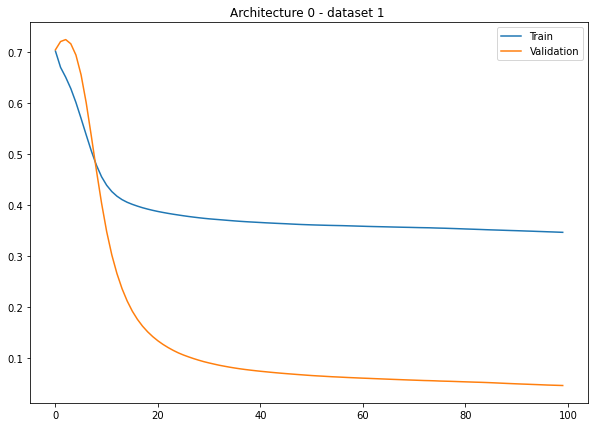

------ dataset 2_1 -------


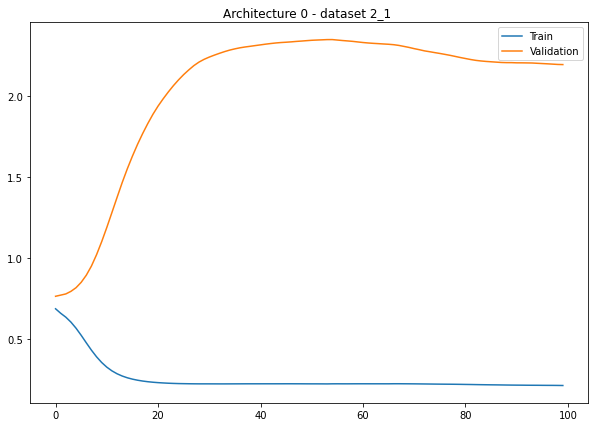

------ dataset 2_2 -------


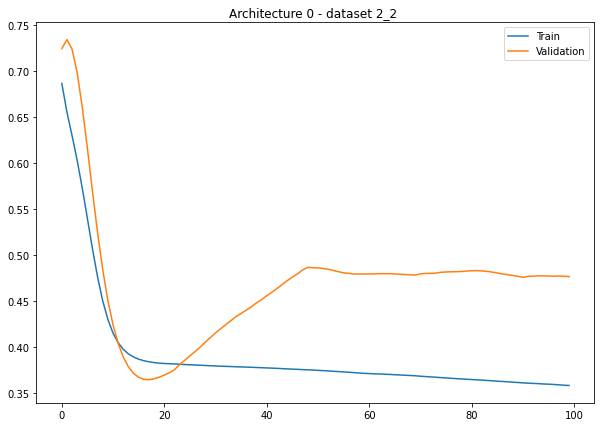

------ dataset 3_1 -------


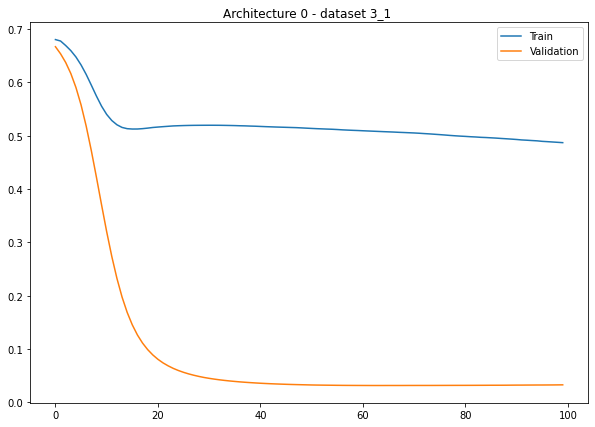

------ dataset 3_2 -------


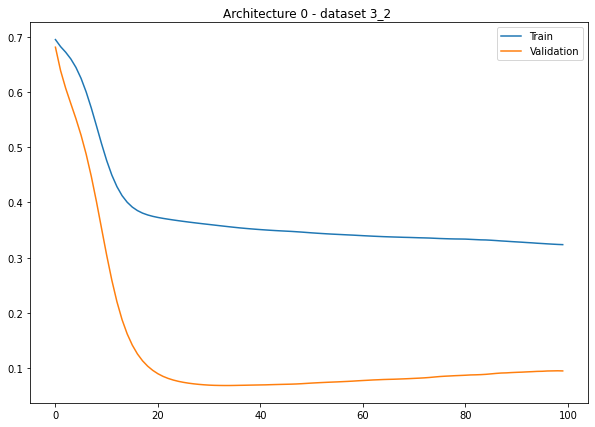

------ dataset PCA -------


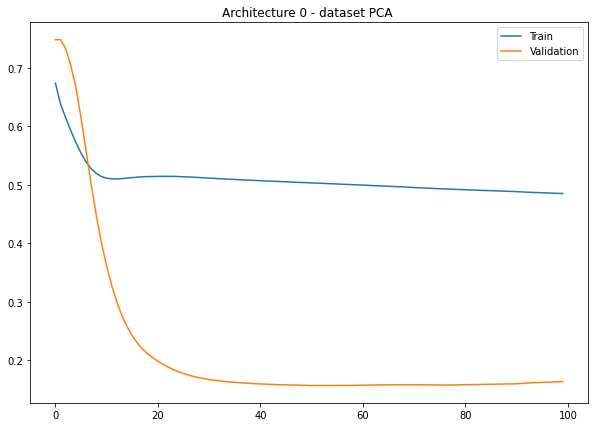

------ dataset UMAP -------


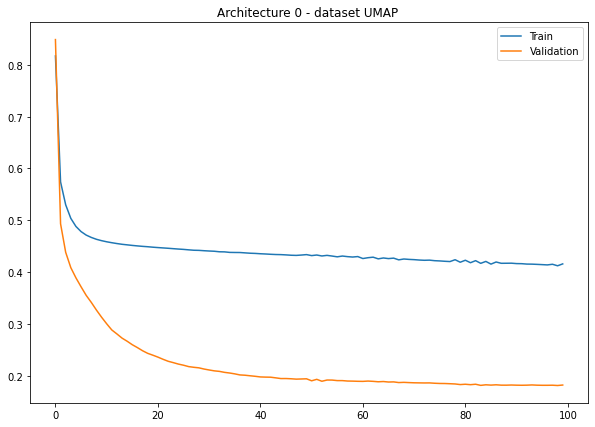

In [109]:
for dataset in dataset_nn.keys():
    
    print(f'------ {dataset} -------')    
    start_train = time.time()

    model = NeuralNetModel0(n_inputs=dataset_nn.get(f'{dataset}').get('X_train').shape[1])
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

    train_loss, val_loss = train_neural_net(model, dataset_nn.get(f'{dataset}').get('train_data_loader'), dataset_nn.get(f'{dataset}').get('val_data_loader'), criterion, epochs)
    end_train = time.time()
    
    plot_neural_net_results(train_loss, val_loss, "Architecture 0", dataset)
    
    train_results_prob = model(dataset_nn.get(f'{dataset}').get('X_train')).detach().numpy()
    validation_results_prob = model(dataset_nn.get(f'{dataset}').get('X_val')).detach().numpy()
    test_results_prob = model(dataset_nn.get(f'{dataset}').get('X_test')).detach().numpy()
    
    train_results = [1 if x >= 0.5 else 0 for x in train_results_prob]
    validation_results = [1 if x >= 0.5 else 0 for x in validation_results_prob]
    test_results = [1 if x >= 0.5 else 0 for x in test_results_prob]
    
    
    train_f1 = f1_score(dataset_nn.get(f'{dataset}').get('y_train').detach().numpy(), train_results)
    validation_f1 = f1_score(dataset_nn.get(f'{dataset}').get('y_val').detach().numpy(), validation_results)
    test_f1 = f1_score(dataset_nn.get(f'{dataset}').get('y_test').detach().numpy(), test_results)
    
    fpr, tpr, thresholds = roc_curve(dataset_nn.get(f'{dataset}').get('y_test').detach().numpy(),
                                     test_results_prob, pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(dataset_nn.get(f'{dataset}').get('y_test').detach().numpy(), test_results_prob)
        
    datasets.get(f'{dataset}').update({'nn_0': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'total_time': end_train - start_train, 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    
    

##### Neural Networks : Architecture 1

In [95]:
# Two layer Neural Net and Dropout

#Layer size
n_hidden1 = 50 # 300  # Number of hidden nodes
n_hidden2 = 100 # 100
n_output =  1   # Number of output nodes = for binary classifier


class NeuralNetModel1(nn.Module):
    def __init__(self, n_inputs=n_input_dim):
        super(NeuralNetModel1, self).__init__()
        self.layer_1 = nn.Linear(n_inputs, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
    

In [96]:
learning_rate = 0.1  # 0.01, 0.001
epochs = 100

------ dataset 1 -------


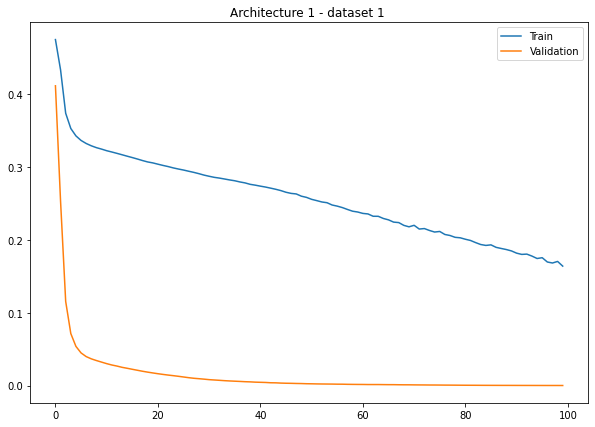

------ dataset 2_1 -------


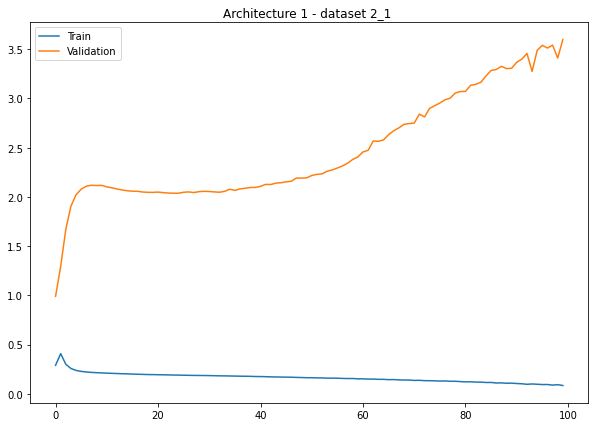

------ dataset 2_2 -------


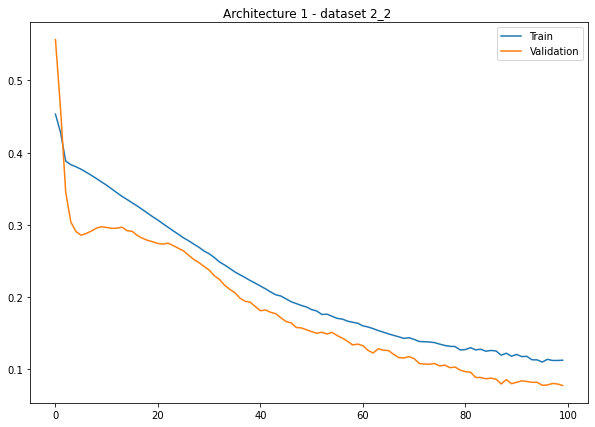

------ dataset 3_1 -------


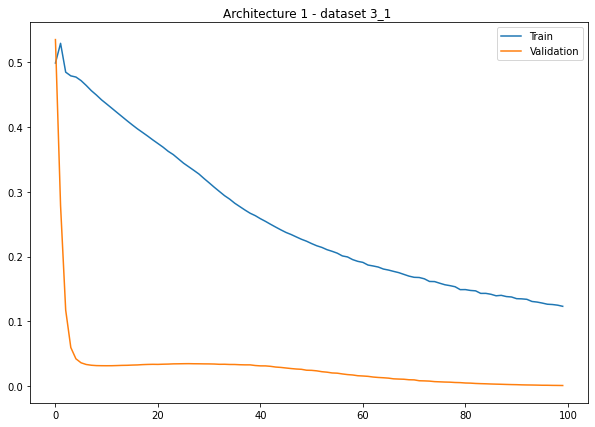

------ dataset 3_2 -------


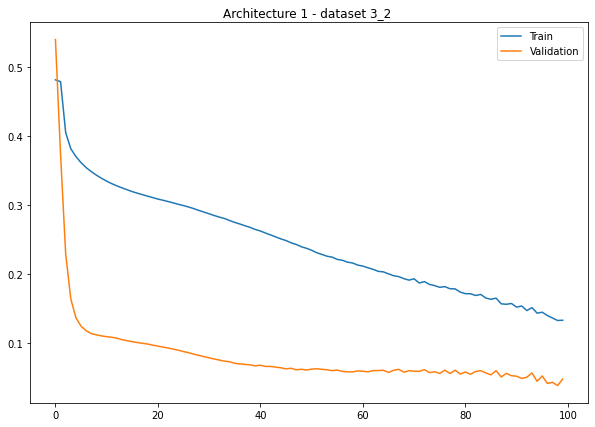

------ dataset PCA -------


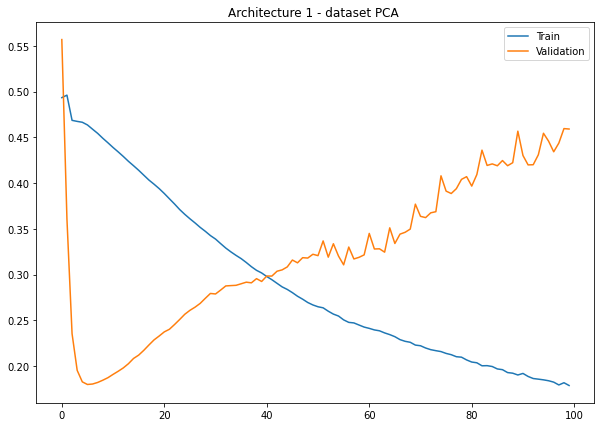

------ dataset UMAP -------


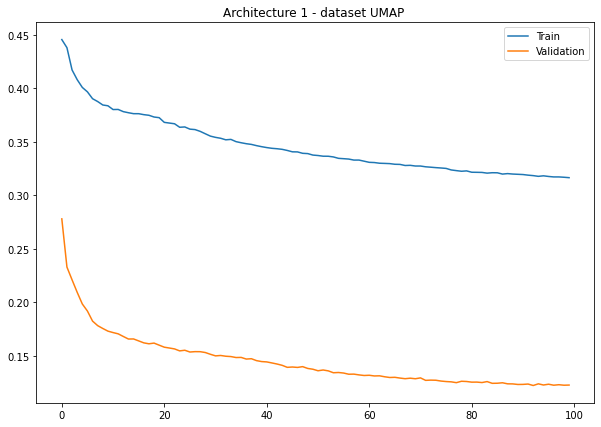

In [97]:
for dataset in dataset_nn.keys():
    
    print(f'------ {dataset} -------')    
    start_train = time.time()

    model = NeuralNetModel1(n_inputs=dataset_nn.get(f'{dataset}').get('X_train').shape[1])
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

    train_loss, val_loss = train_neural_net(model, dataset_nn.get(f'{dataset}').get('train_data_loader'), dataset_nn.get(f'{dataset}').get('val_data_loader'), criterion, epochs)
    end_train = time.time()
    
    plot_neural_net_results(train_loss, val_loss, "Architecture 1", dataset)
    
    train_results_prob = model(dataset_nn.get(f'{dataset}').get('X_train')).detach().numpy()
    validation_results_prob = model(dataset_nn.get(f'{dataset}').get('X_val')).detach().numpy()
    test_results_prob = model(dataset_nn.get(f'{dataset}').get('X_test')).detach().numpy()
    
    train_results = [1 if x >= 0.5 else 0 for x in train_results_prob]
    validation_results = [1 if x >= 0.5 else 0 for x in validation_results_prob]
    test_results = [1 if x >= 0.5 else 0 for x in test_results_prob]
    
    
    train_f1 = f1_score(dataset_nn.get(f'{dataset}').get('y_train').detach().numpy(), train_results)
    validation_f1 = f1_score(dataset_nn.get(f'{dataset}').get('y_val').detach().numpy(), validation_results)
    test_f1 = f1_score(dataset_nn.get(f'{dataset}').get('y_test').detach().numpy(), test_results)
    
    fpr, tpr, thresholds = roc_curve(dataset_nn.get(f'{dataset}').get('y_test').detach().numpy(),
                                     test_results_prob, pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(dataset_nn.get(f'{dataset}').get('y_test').detach().numpy(), test_results_prob)
        
    datasets.get(f'{dataset}').update({'nn_1': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'total_time': end_train - start_train, 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    

##### Neural Networks : Architecture 2

In [110]:
n_input_dim = datasets.get(f'{dataset}').get('x_train').shape[1]

#Layer size
n_hidden1 = 300  # Number of hidden nodes
n_hidden2 = 200
n_hidden3 = 100
n_hidden4 = 50
n_output =  1   # Number of output nodes = for binary classifier


class NeuralNetModel2(nn.Module):
    def __init__(self, n_inputs=n_input_dim):
        super(NeuralNetModel2, self).__init__()
        self.layer_1 = nn.Linear(n_inputs, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_3 = nn.Linear(n_hidden2, n_hidden3) 
        self.layer_4 = nn.Linear(n_hidden3, n_hidden4)
        self.layer_out = nn.Linear(n_hidden4, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        self.batchnorm3 = nn.BatchNorm1d(n_hidden3)
        self.batchnorm4 = nn.BatchNorm1d(n_hidden4)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x

In [112]:
learning_rate = 0.1  # 0.01, 0.001
epochs = 100

------ dataset 1 -------


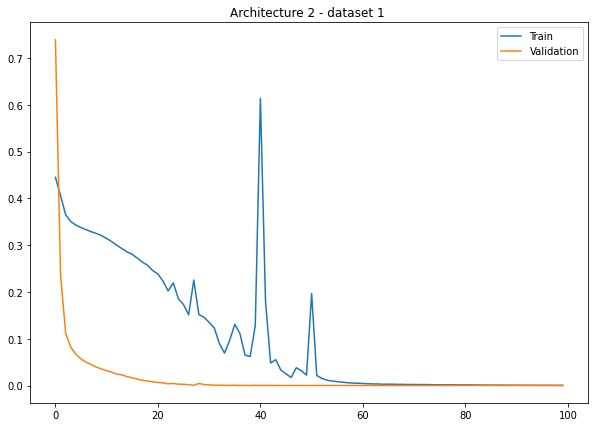

divide by zero encountered in log
invalid value encountered in multiply


------ dataset 2_1 -------


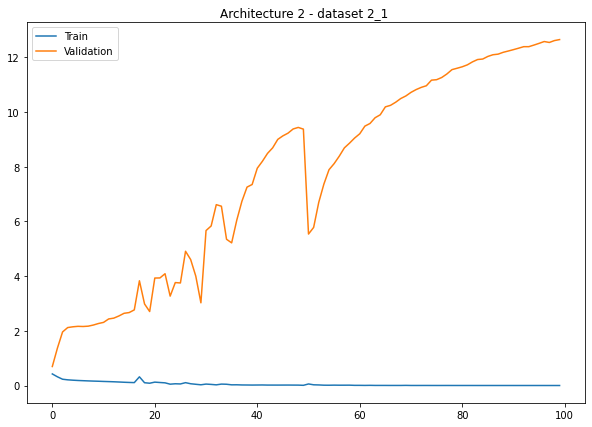

divide by zero encountered in log
invalid value encountered in multiply


------ dataset 2_2 -------


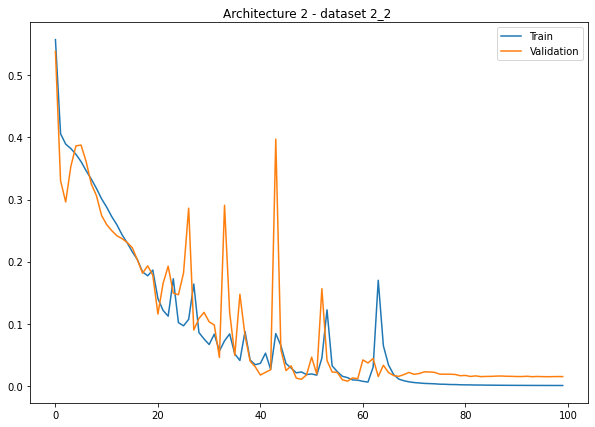

divide by zero encountered in log
invalid value encountered in multiply


------ dataset 3_1 -------


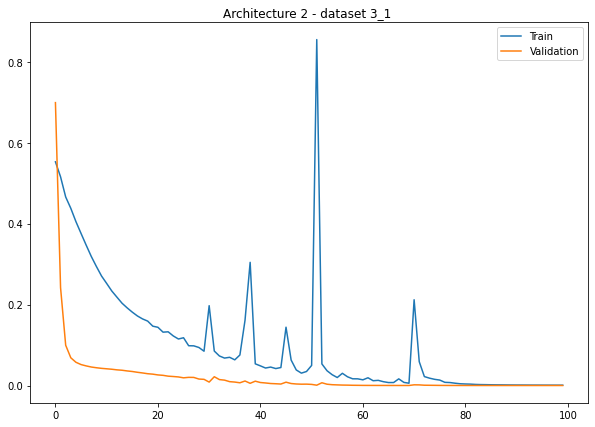

divide by zero encountered in log
invalid value encountered in multiply


------ dataset 3_2 -------


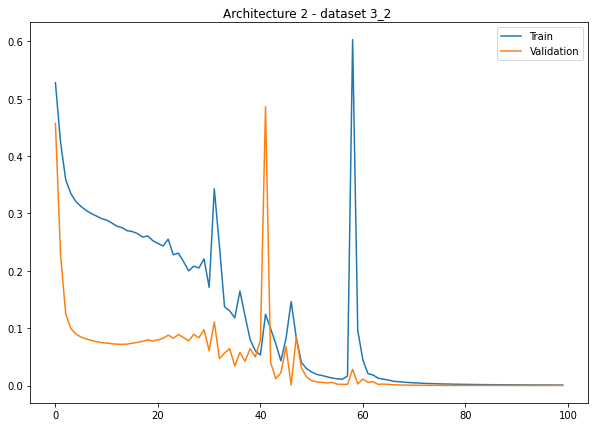

divide by zero encountered in log
invalid value encountered in multiply


------ dataset PCA -------


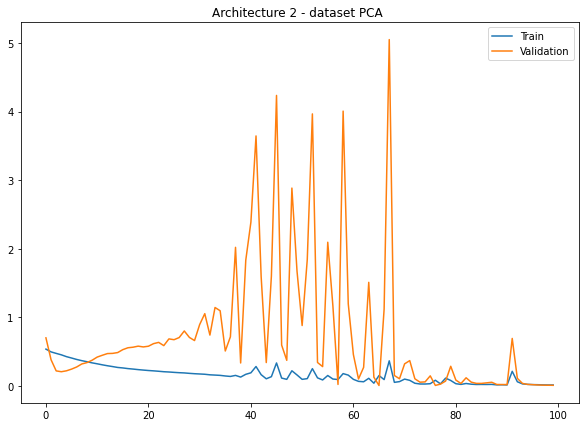

divide by zero encountered in log
invalid value encountered in multiply


------ dataset UMAP -------


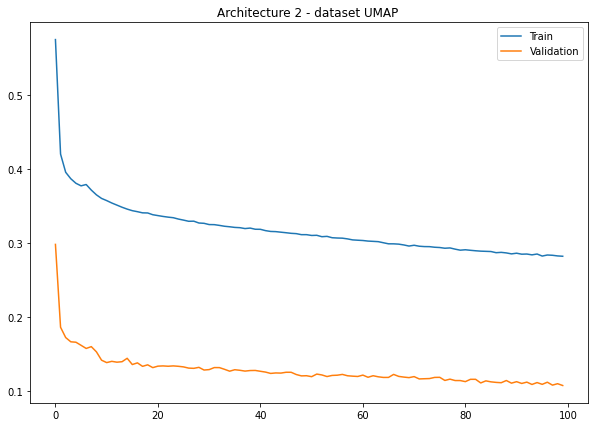

In [113]:
for dataset in dataset_nn.keys():
    
    print(f'------ {dataset} -------')    
    start_train = time.time()

    model = NeuralNetModel2(n_inputs=dataset_nn.get(f'{dataset}').get('X_train').shape[1])
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

    train_loss, val_loss = train_neural_net(model, dataset_nn.get(f'{dataset}').get('train_data_loader'), dataset_nn.get(f'{dataset}').get('val_data_loader'), criterion, epochs)
    end_train = time.time()
    
    plot_neural_net_results(train_loss, val_loss, "Architecture 2", dataset)
    
    train_results_prob = model(dataset_nn.get(f'{dataset}').get('X_train')).detach().numpy()
    validation_results_prob = model(dataset_nn.get(f'{dataset}').get('X_val')).detach().numpy()
    test_results_prob = model(dataset_nn.get(f'{dataset}').get('X_test')).detach().numpy()
    
    train_results = [1 if x >= 0.5 else 0 for x in train_results_prob]
    validation_results = [1 if x >= 0.5 else 0 for x in validation_results_prob]
    test_results = [1 if x >= 0.5 else 0 for x in test_results_prob]
    
    
    train_f1 = f1_score(dataset_nn.get(f'{dataset}').get('y_train').detach().numpy(), train_results)
    validation_f1 = f1_score(dataset_nn.get(f'{dataset}').get('y_val').detach().numpy(), validation_results)
    test_f1 = f1_score(dataset_nn.get(f'{dataset}').get('y_test').detach().numpy(), test_results)
    
    fpr, tpr, thresholds = roc_curve(dataset_nn.get(f'{dataset}').get('y_test').detach().numpy(),
                                     test_results_prob, pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(dataset_nn.get(f'{dataset}').get('y_test').detach().numpy(), test_results_prob)
        
    datasets.get(f'{dataset}').update({'nn_2': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'total_time': end_train - start_train, 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    

#### Final Ensemble 

##### Stacking  

In [ ]:
for dataset in datasets.keys():
    estimators = []
    for algorithm in ['knn', 'lr', 'svc', 'rfc', 'ada', 'gb', 'lgb']:  # Exclude final_estimator from this list ('xgb')
        print(f'Adding {algorithm} for dataset {dataset}')
        estimators.append((algorithm, datasets.get(dataset).get(algorithm).get('model')))
    
    model = StackingClassifier(estimators=estimators, final_estimator=datasets.get(dataset).get('xgb'))
    
    model.fit(datasets.get(f'{dataset}').get('x_train'), datasets.get(f'{dataset}').get('y_train'))
    train_results = model.predict(datasets.get(f'{dataset}').get('x_train'))
    validation_results = model.predict(datasets.get(f'{dataset}').get('x_val'))
    test_results = model.predict(datasets.get(f'{dataset}').get('x_test'))
    test_probability_results = model.predict_proba(datasets.get(f'{dataset}').get('x_test'))
    
    train_f1 = f1_score(datasets.get(f'{dataset}').get('y_train'), train_results)
    validation_f1 = f1_score(datasets.get(f'{dataset}').get('y_val'), validation_results)
    test_f1 = f1_score(datasets.get(f'{dataset}').get('y_test'), test_results)
    
    fpr, tpr, thresholds = roc_curve(datasets.get(f'{dataset}').get('y_test'), test_probability_results[:, 1], pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(datasets.get(f'{dataset}').get('y_test'), test_probability_results)
        
    datasets.get(f'{dataset}').update({'stacking': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'random_search_time': end_random_search - start_random_search,
                                               'grid_search_time': end_grid_search - start_grid_search,
                                               'total_time': (end_random_search - start_random_search) + (end_grid_search - start_grid_search), 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    print(f'F1, Train results: {train_f1}, Validation results: {validation_f1}, Test results: {test_f1},  Overfitting: {train_f1 - validation_f1 >= overfitting_threshold}')
    

##### Voting

In [ ]:
for dataset in datasets.keys():
    estimators = []
    for algorithm in ['knn', 'lr', 'svc', 'rfc', 'ada', 'gb', 'lgb', 'xgb']:  # Exclude final_estimator from this list ('xgb')
        print(f'Adding {algorithm} for dataset {dataset}')
        estimators.append((algorithm, datasets.get(dataset).get(algorithm).get('model')))
    
    model = VotingClassifier(estimators=estimators, voting='soft') # no predict probabilty if hard
    
    model.fit(datasets.get(f'{dataset}').get('x_train'), datasets.get(f'{dataset}').get('y_train'))
    train_results = model.predict(datasets.get(f'{dataset}').get('x_train'))
    validation_results = model.predict(datasets.get(f'{dataset}').get('x_val'))
    test_results = model.predict(datasets.get(f'{dataset}').get('x_test'))
    test_probability_results = model.predict_proba(datasets.get(f'{dataset}').get('x_test'))
    
    train_f1 = f1_score(datasets.get(f'{dataset}').get('y_train'), train_results)
    validation_f1 = f1_score(datasets.get(f'{dataset}').get('y_val'), validation_results)
    test_f1 = f1_score(datasets.get(f'{dataset}').get('y_test'), test_results)
    
    fpr, tpr, thresholds = roc_curve(datasets.get(f'{dataset}').get('y_test'), test_probability_results[:, 1], pos_label=1)
    test_auc = auc(fpr, tpr)
    
    test_log_loss = log_loss(datasets.get(f'{dataset}').get('y_test'), test_probability_results)
        
    datasets.get(f'{dataset}').update({'voting': {
                                               'train_f1': train_f1,
                                               'validation_f1': validation_f1,
                                               'overfitting': train_f1 - validation_f1 >= overfitting_threshold,
                                               'model': model,
                                               'random_search_time': end_random_search - start_random_search,
                                               'grid_search_time': end_grid_search - start_grid_search,
                                               'total_time': (end_random_search - start_random_search) + (end_grid_search - start_grid_search), 
                                               'test_metrics': [test_f1, test_auc, test_log_loss],
                                               'test_results': test_results
                                              }})
    print(f'F1, Train results: {train_f1}, Validation results: {validation_f1}, Test results: {test_f1},  Overfitting: {train_f1 - validation_f1 >= overfitting_threshold}')
    

## Results

### Results benchmark

In [ ]:
datasets.keys()

In [ ]:
for algorithm in ['knn', 'lr', 'svc', 'rfc', 'xgb', 'ada', 'gb', 'lgb', 'stacking', 'voting']:
    for dataset in datasets.keys():
        print(f"{dataset} in algorithm {algorithm}")
        print(datasets.get(dataset).get(algorithm))

### Model explainabilty

Only results from  top rated algorithms will be passed through model explainabilty since the pocess needs to be manually interpretable.

In [ ]:
X_train = decision_tree.iloc[0:800,:]
X_train.drop(['HeartDisease'], axis=1, inplace=True)

In [ ]:
X_valid = decision_tree.iloc[800:,:]
X_valid.drop(['HeartDisease'], axis=1, inplace=True)

In [ ]:
f = lambda x: knn_model.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_valid.iloc[0:1000,:])

In [ ]:
shap.plots.waterfall(shap_values[23]) #num of patient 0-118

In [ ]:
"""
Hyperparameter for KNN is {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}

"""


explainer = shap.Explainer(knn_model)
shap_values = explainer(decision_tree.drop(['HeartDisease'], axis=1))
shap.plots.waterfall(shap_values[0])